In [377]:
# Data Wrangling libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import pickle
import missingno
from collections import Counter

# Machine learning models libraries
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation library
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning library
from sklearn.model_selection import GridSearchCV

# Remove warnings library
import warnings
warnings.filterwarnings('ignore')

In [378]:
# Access data from Data dir.
data_path = 'Data/'
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
ss = pd.read_csv("Data/gender_submission.csv")

In [379]:
data_type = {
    'PassengerId': str,
    'Survived': bool,
    'Pclass': 'category', # Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
    'Name': str,
    'Sex': 'category',
    'Age': float,
    'SibSp': 'uint8', # number of siblings/spouses aboard
    'Parch': 'uint8', # number of parents/children aboard
    'Ticket': str, # Ticket number
    'Fare': float, # Passenger fare
    'Cabin': str, # Cabin number
    'Embarked': 'category'} # Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

# load and serialize dataframes for later use in preprocessing notebook
for ds_name in ['test', 'train']: # last one is used in this document
    df = pd.read_csv(data_path+ds_name+'.csv', dtype=data_type)
    with open(data_path+ds_name+'_dv.obj', 'wb') as file:
        pickle.dump(df, file)

In [380]:
#view the data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


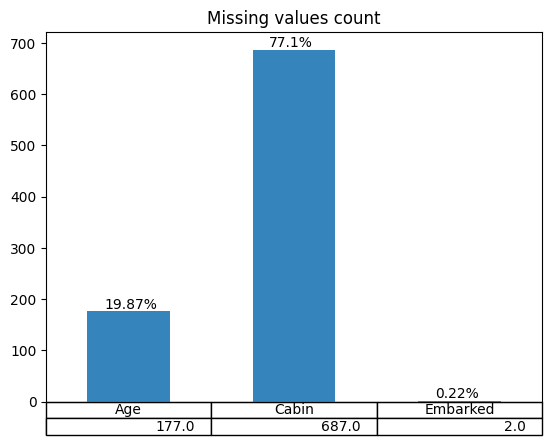

In [381]:
# Missing values

# number of rows
rows_length = df.shape[0]
# fields with missing value count
fields_with_nan_length = df.isna().sum().where(lambda x : x > 0).dropna()

ax = fields_with_nan_length \
.plot(kind='bar', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels


# write percentage on top of each bar
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

In [382]:
# some statistics about the numerical data
df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [383]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [384]:
ss.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.363636
std,120.810458,0.481622
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


<Axes: >

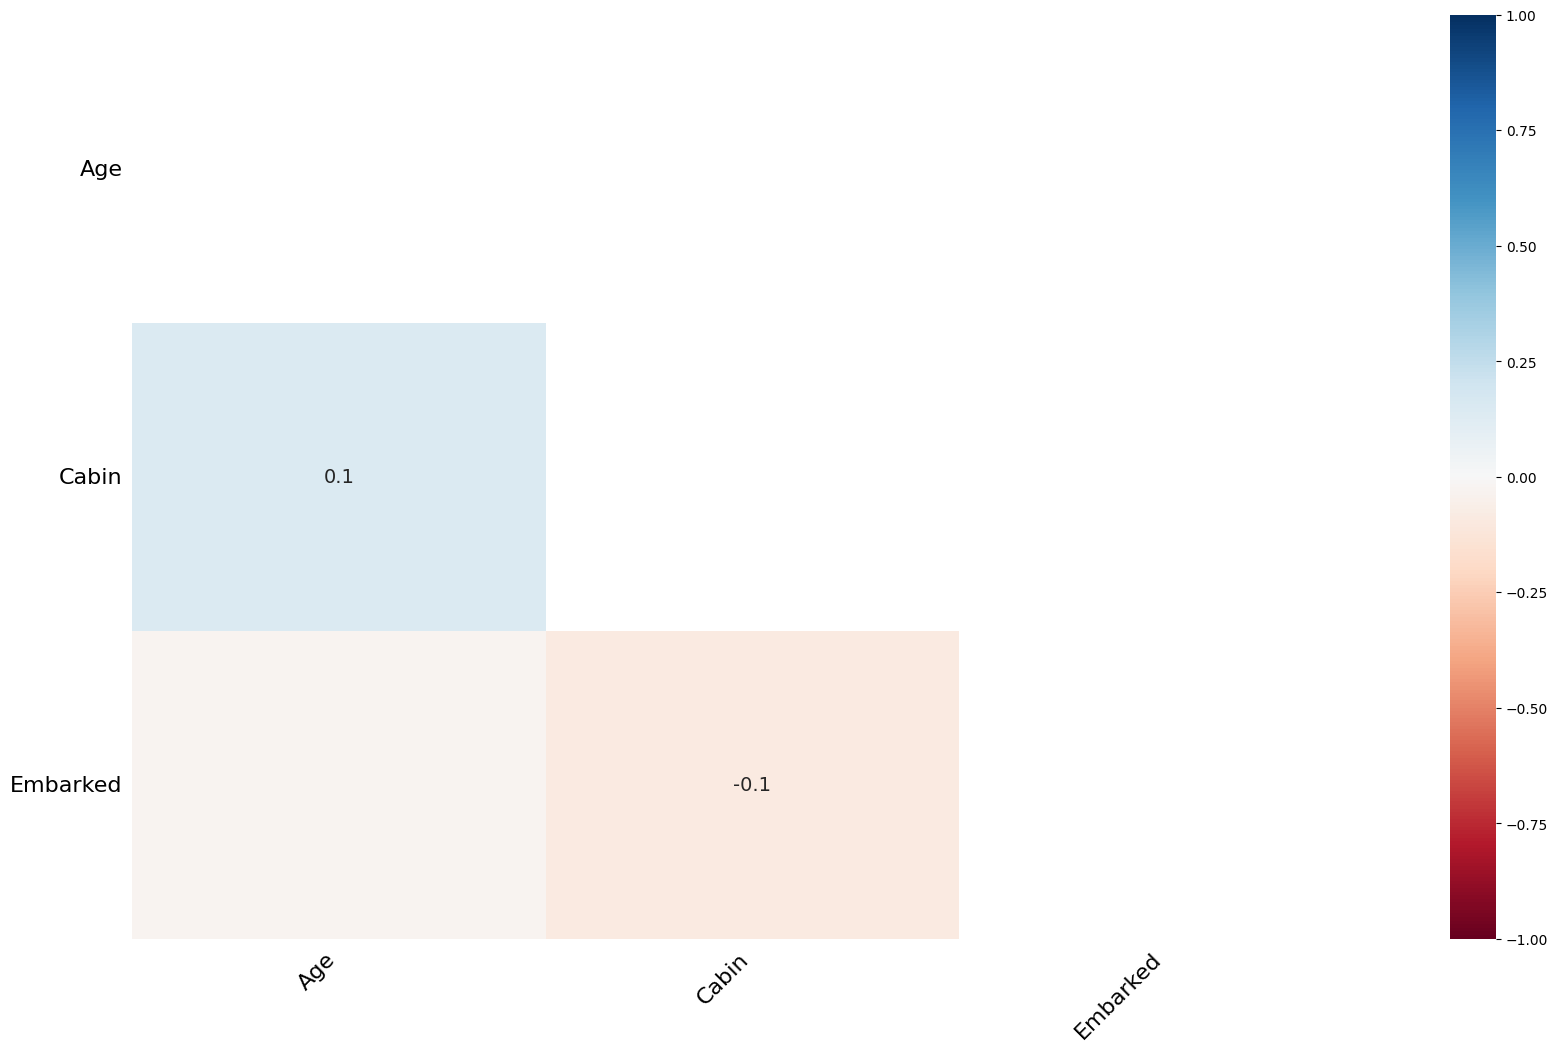

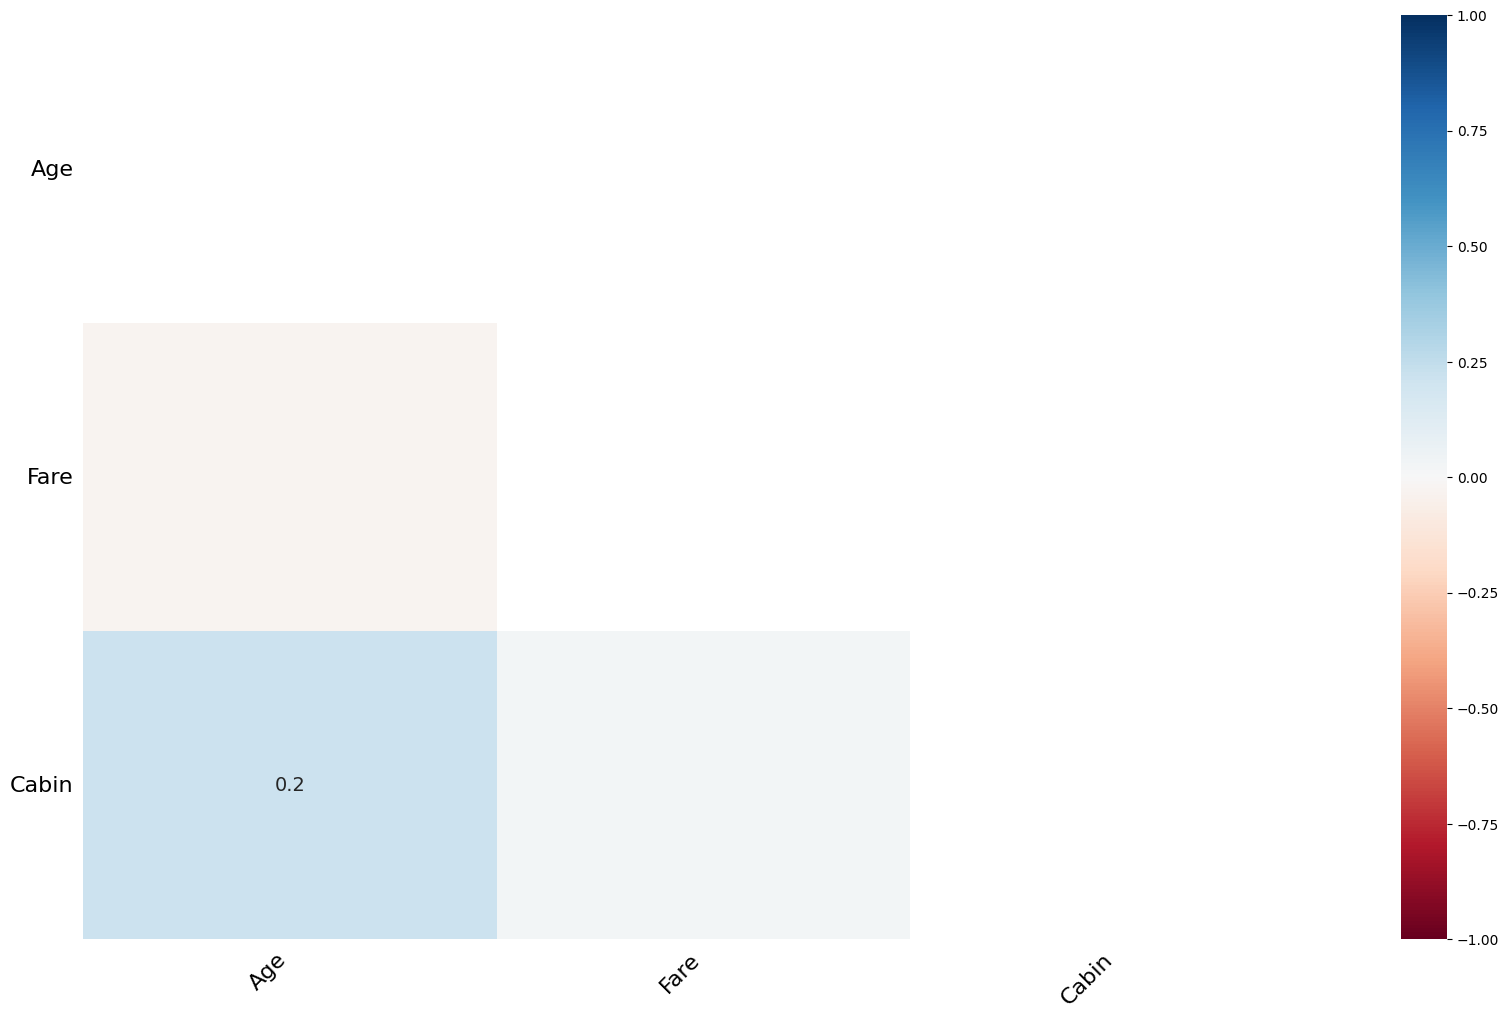

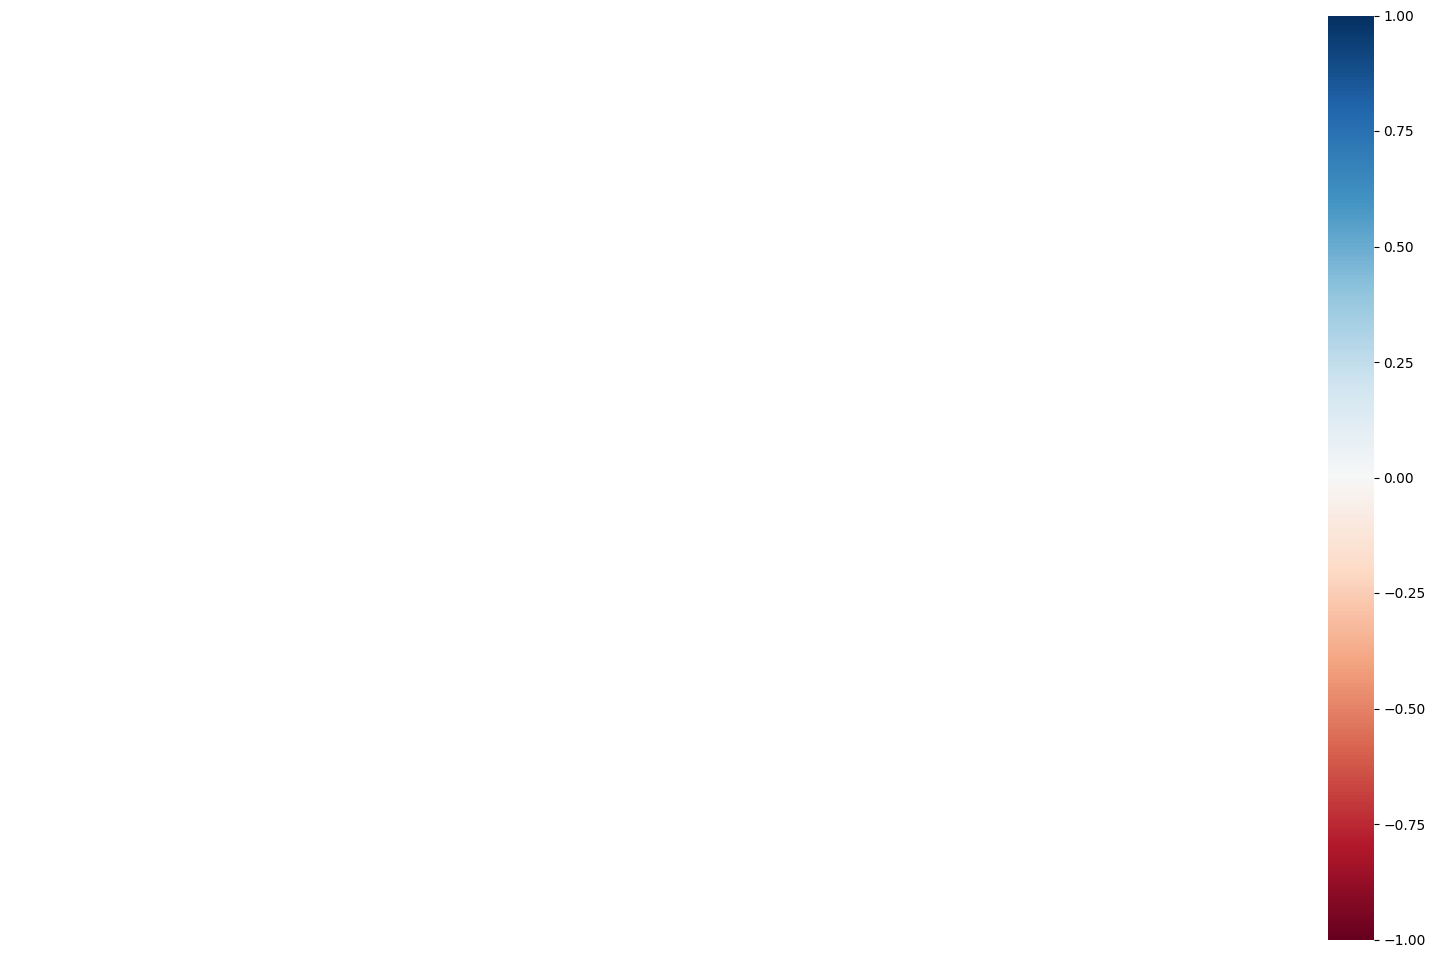

In [385]:

missingno.heatmap(df)
missingno.heatmap(test)
missingno.heatmap(ss)

<Axes: >

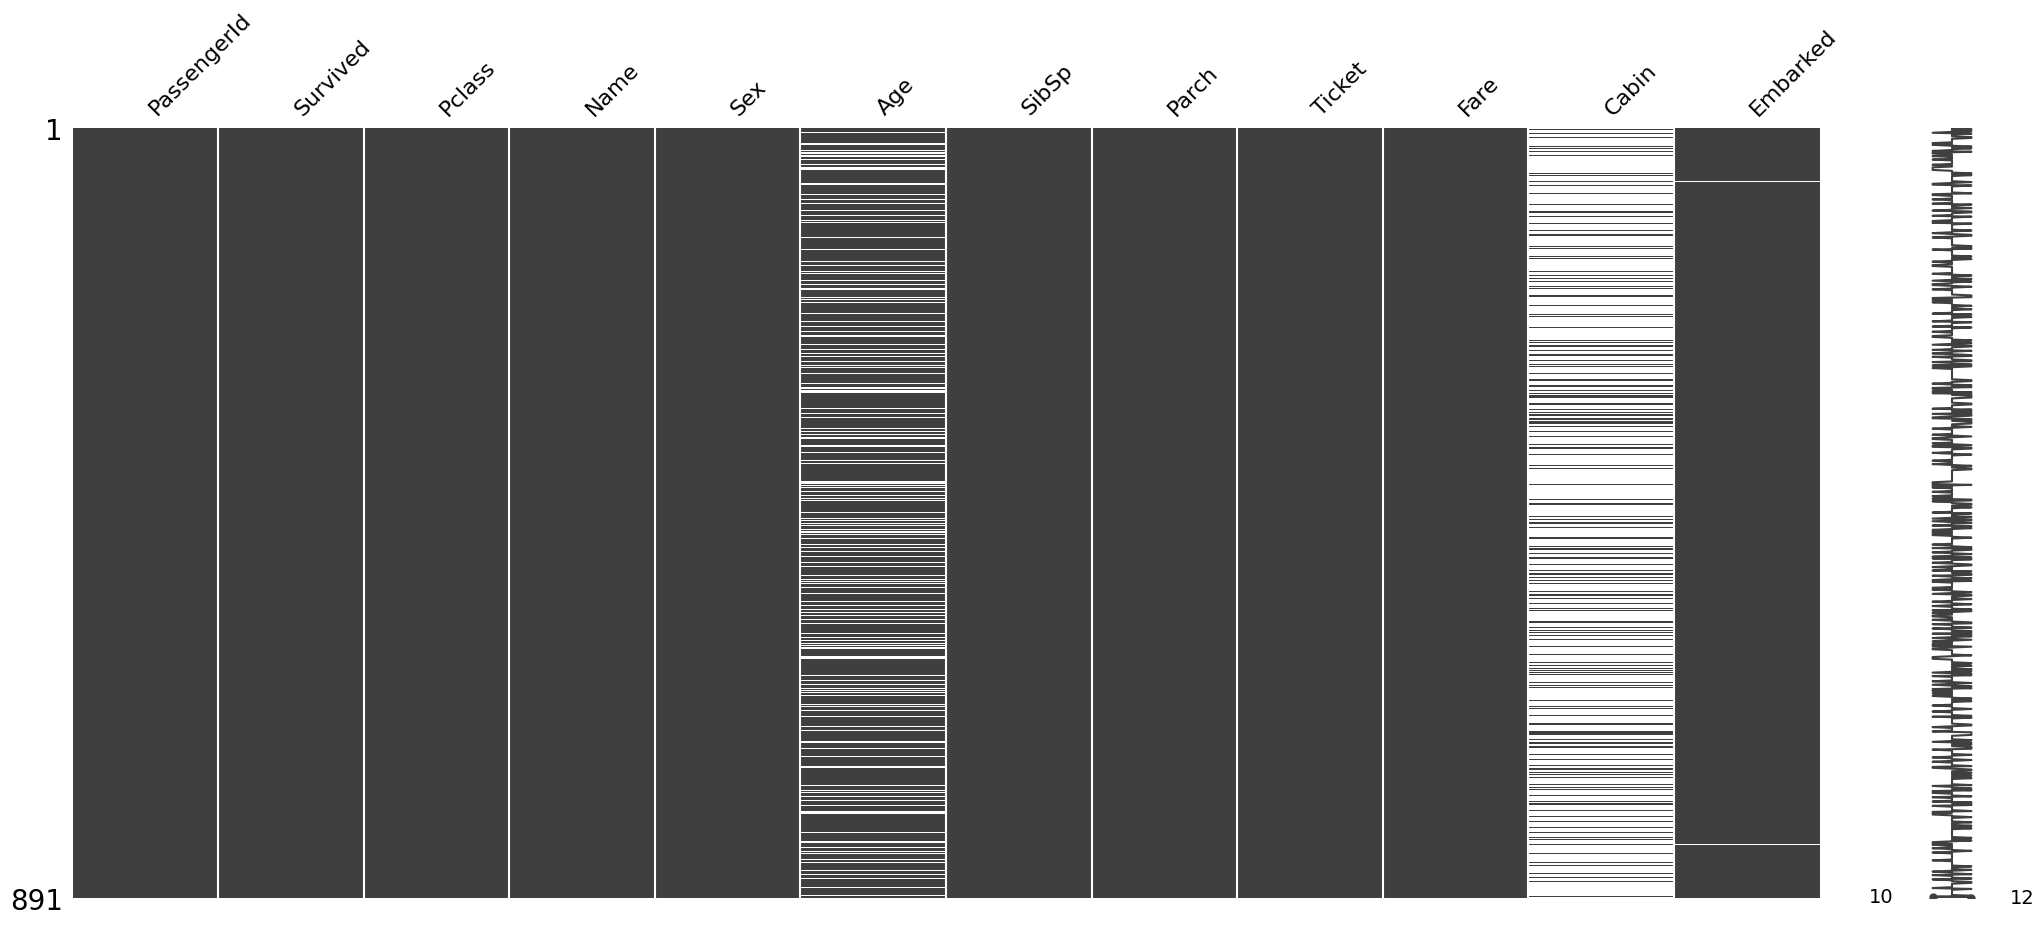

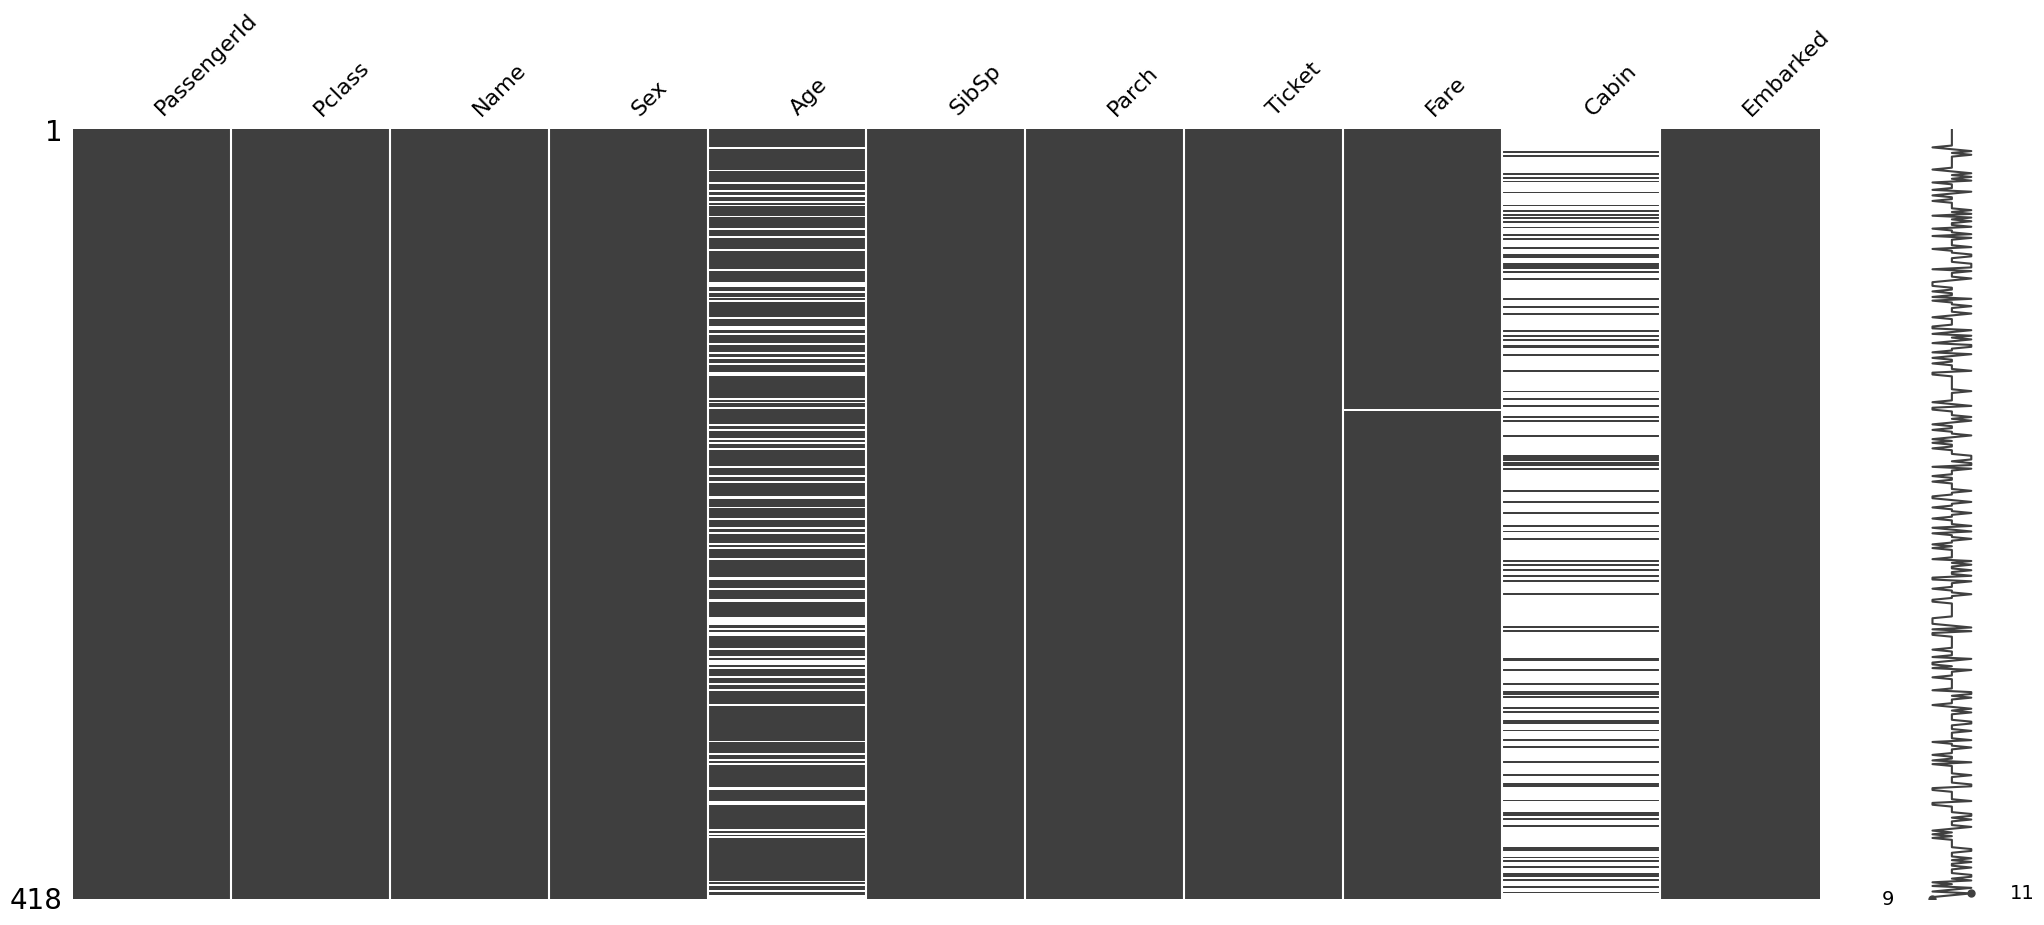

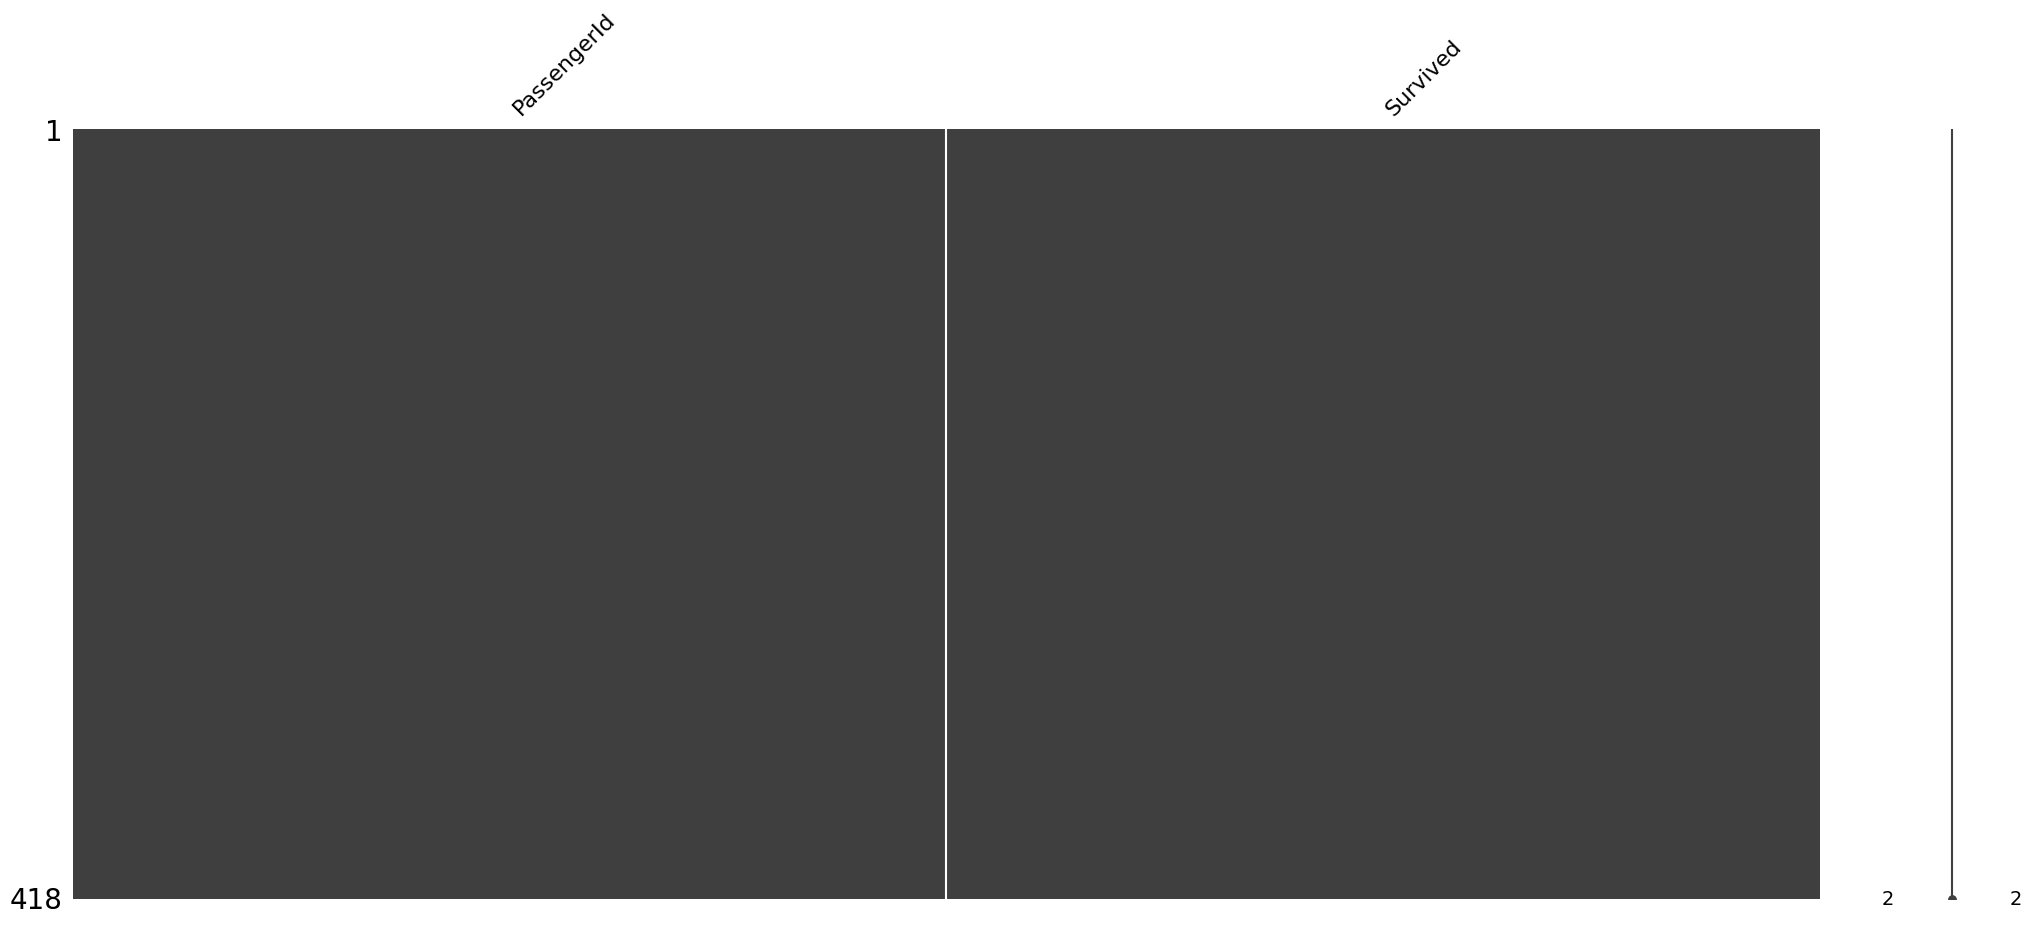

In [386]:

missingno.matrix(df)
missingno.matrix(test)
missingno.matrix(ss)

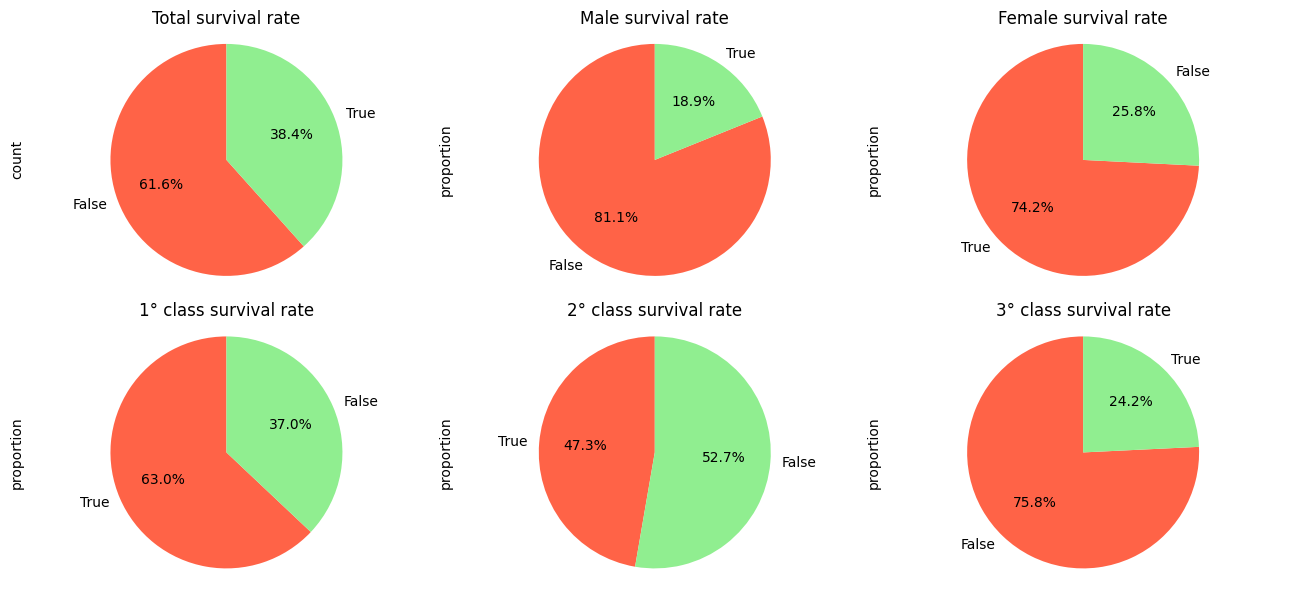

In [387]:
# Specifies the parameters of our graphs
plt.figure(figsize=(13,6))
plot_params = {
    'kind': 'pie',
    'startangle': 90,
    'autopct': '%1.1f%%',
    'colors': ['tomato', 'lightgreen']
}


# Plots a bar graph of those who surived vs those who did not
plt.subplot2grid((2,3), (0,0))
df.Survived.value_counts() \
.plot(title='Total survival rate', **plot_params).axis('equal')


# Survival rate wrt Sex
df_male = df.Survived[df.Sex == 'male'].value_counts(normalize=True, sort=False)
df_female = df.Survived[df.Sex == 'female'].value_counts(normalize=True, sort=False)

## male survival plot
plt.subplot2grid((2,3),(0,1))
df_male.plot(title='Male survival rate', **plot_params).axis('equal')

## female survival plot
plt.subplot2grid((2,3),(0,2))
df_female.plot(title='Female survival rate', **plot_params).axis('equal')


# Survival rate wrt Pclass
for i in range(3):
    plt.subplot2grid((2,3),(1,i))
    df.Survived[df.Pclass == str(i+1)].value_counts(normalize=True, sort=False) \
    .plot(title=str(i+1)+'° class survival rate', **plot_params).axis('equal')


plt.tight_layout()
plt.show()

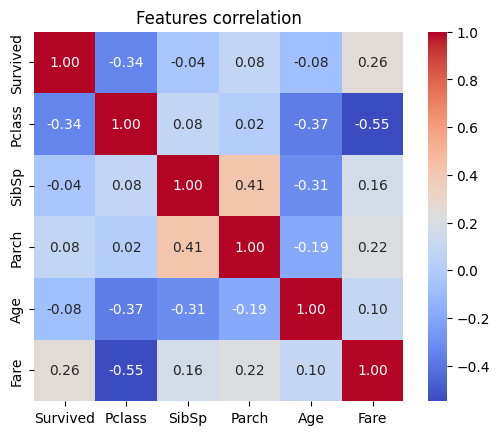

In [388]:
#Correlation between features
sns.heatmap(df[['Survived','Pclass', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),square=True, annot = True, fmt = '.2f', cmap = 'coolwarm').set_title('Features correlation');

In [389]:
# Value counts of the male and female
train['Sex'].value_counts(dropna = False)

Sex
male      577
female    314
Name: count, dtype: int64

In [390]:
# Mean of survival by male and female
train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

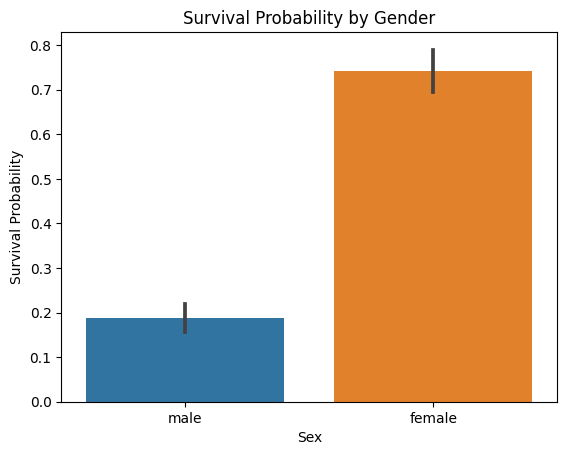

In [391]:
sns.barplot(x = 'Sex', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

# Female passengers are more likely to survive

In [392]:
# Value counts of the Pclass column 
train['Pclass'].value_counts(dropna = False)

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [393]:
# Mean of survival by passenger class
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival Probability by Passenger Class')

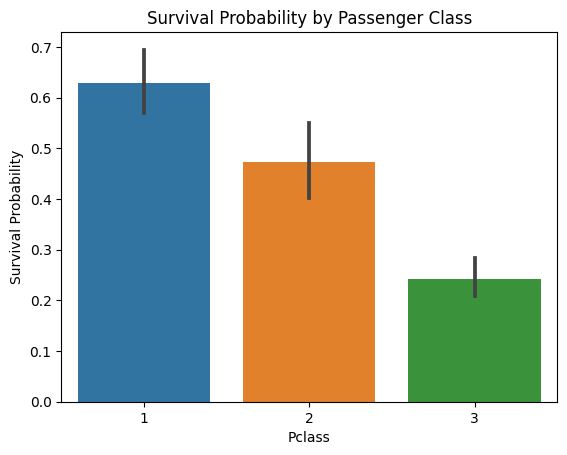

In [394]:
sns.barplot(x = 'Pclass', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

# Survival probability decrease with passenger class, first class passengers are prioritised during evacuation

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

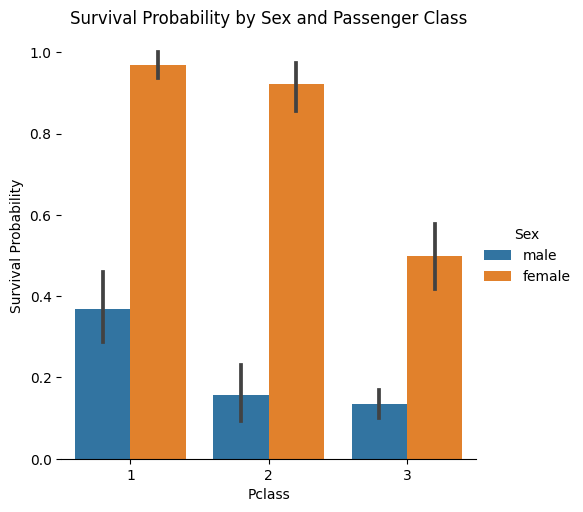

In [395]:
# Survival by gender and passenger class

g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

In [396]:
# Value counts of the Embarked column 

train['Embarked'].value_counts(dropna = False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [397]:
# Mean of survival by point of embarkation

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

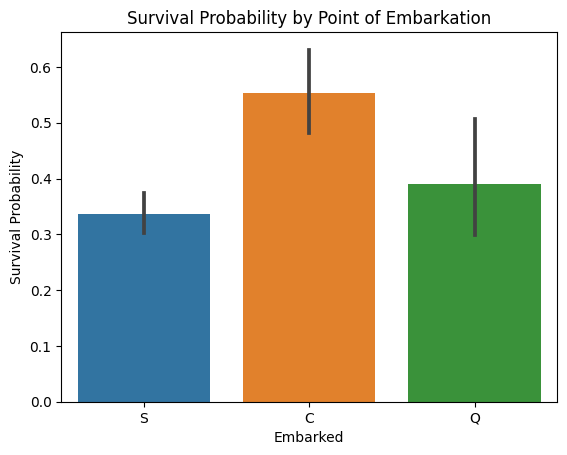

In [398]:
sns.barplot(x = 'Embarked', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

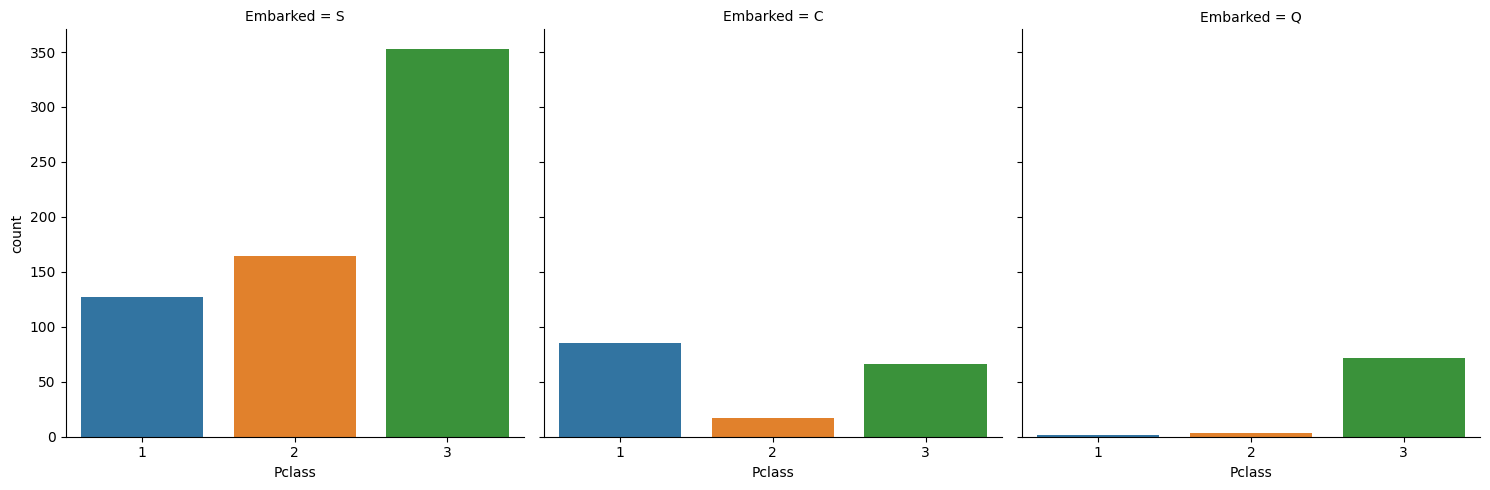

In [399]:
g = sns.catplot(x = 'Pclass', col = 'Embarked' , data = train, kind = 'count')

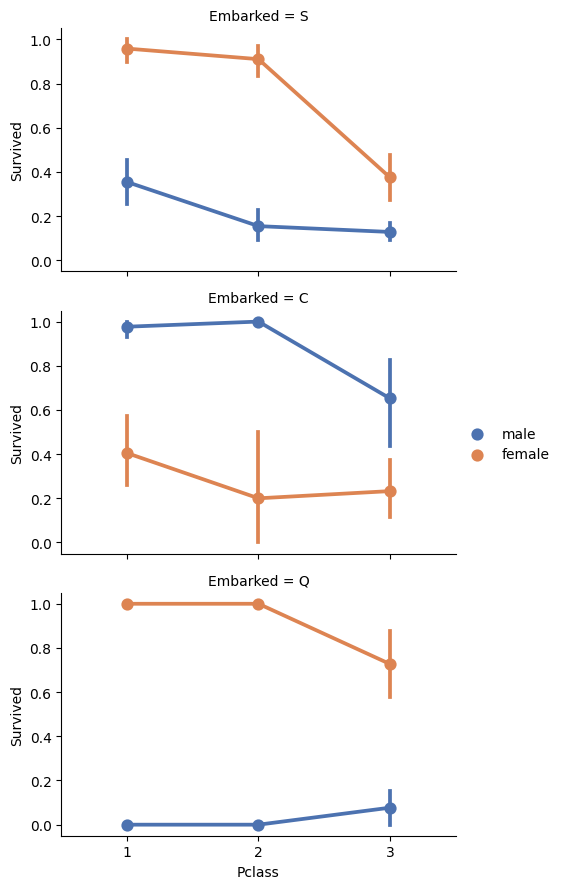

In [400]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train, row = 'Embarked', aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

In [401]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [262]:
train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [263]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


<Axes: >

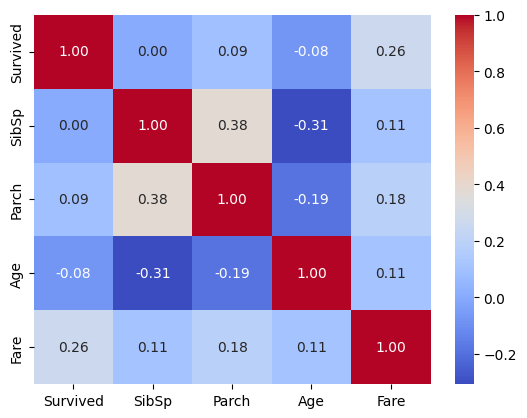

In [264]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

In [265]:
# Value counts of the SibSp column 

train['SibSp'].value_counts(dropna = False)

SibSp
0    608
1    209
2     28
4     18
3     13
5      5
Name: count, dtype: int64

In [266]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

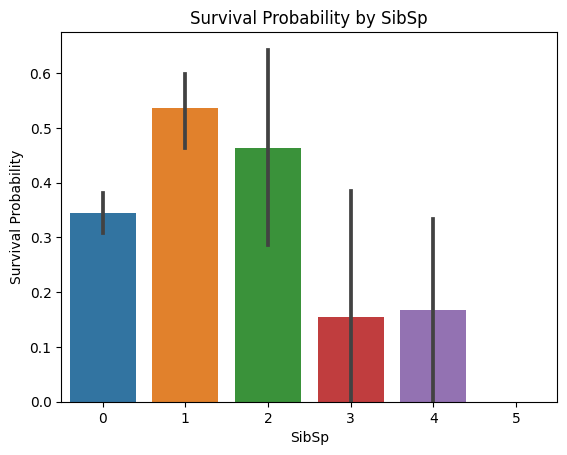

In [267]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

In [268]:
# Value counts of the Parch column 

train['Parch'].value_counts(dropna = False)

Parch
0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [269]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

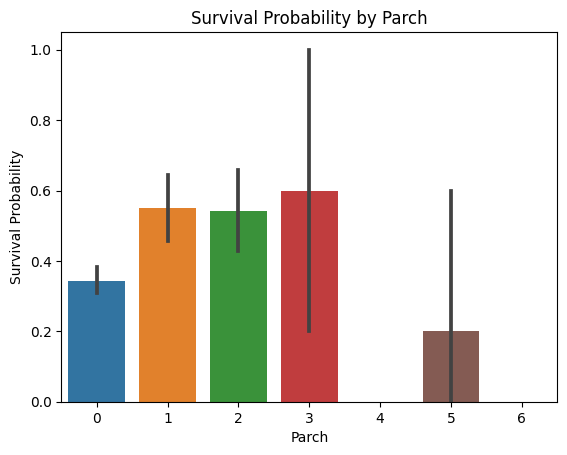

In [270]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

In [271]:
# Null values in Age column 

train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

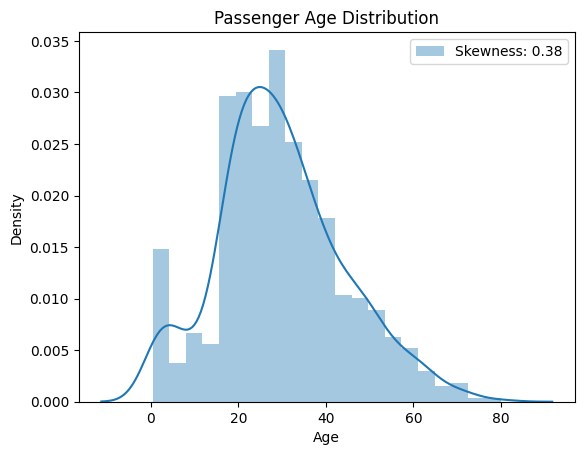

In [272]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

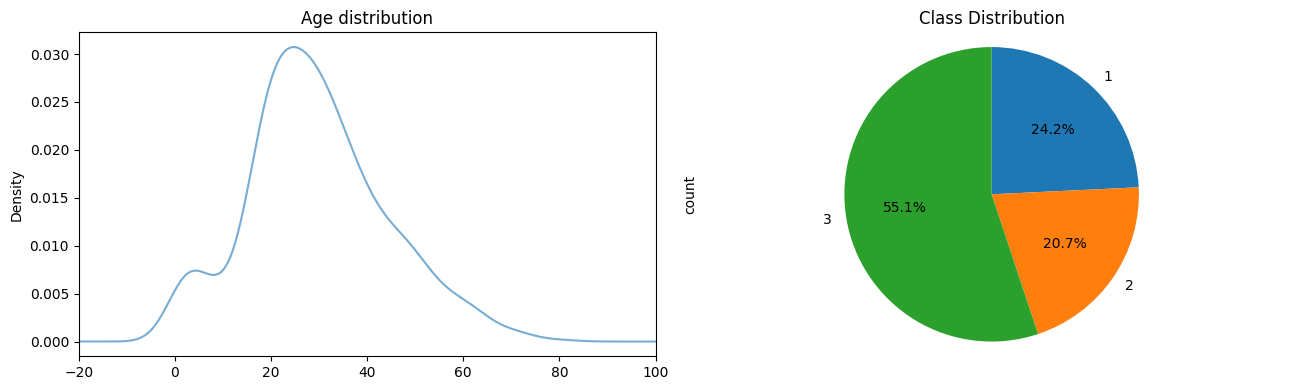

In [273]:
plt.figure(figsize=(13,4))

# plots a bar graph of the age distribution
plt.subplot2grid((1,2), (0,0))
df.Age.plot(kind='kde', alpha=0.6, title='Age distribution', xlim=(-20, 100))

# plots a bar graph of the class distribution
plt.subplot2grid((1,2),(0,1))
df.Pclass.value_counts(sort=False).plot(kind='pie', title='Class Distribution', \
                                        autopct='%1.1f%%', counterclock=False, \
                                        startangle=90).axis('equal')

plt.tight_layout()
plt.show()

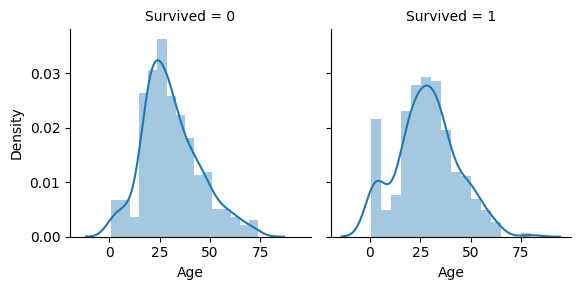

In [274]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

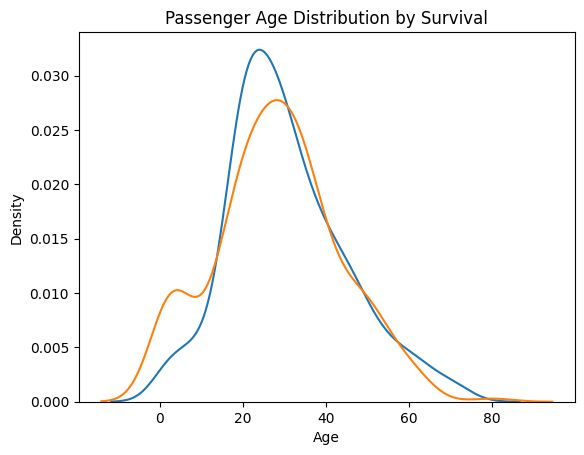

In [275]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

In [276]:
# Null values of Fare column 

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

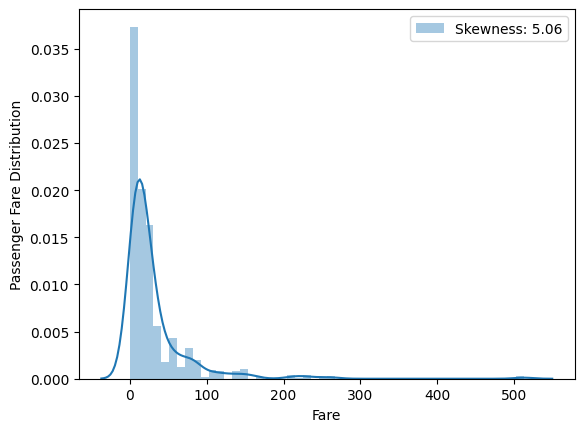

In [277]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

In [278]:
# Drop ticket and cabin features from training and test set
train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)

In [279]:
# Missing values in training set 

train.isnull().sum().sort_values(ascending = False)

Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

In [280]:
# Compute the most frequent value of Embarked in training set

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [281]:
# Fill missing value in Embarked with mode

train['Embarked'].fillna(mode, inplace = True)

In [282]:
# Missing values in test set

test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [283]:
# Compute median of Fare in test set 

median = test['Fare'].dropna().median()
median

14.4542

In [284]:
# Fill missing value in Fare with median

test['Fare'].fillna(median, inplace = True)

In [285]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [286]:
# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [287]:
# Convert Sex into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

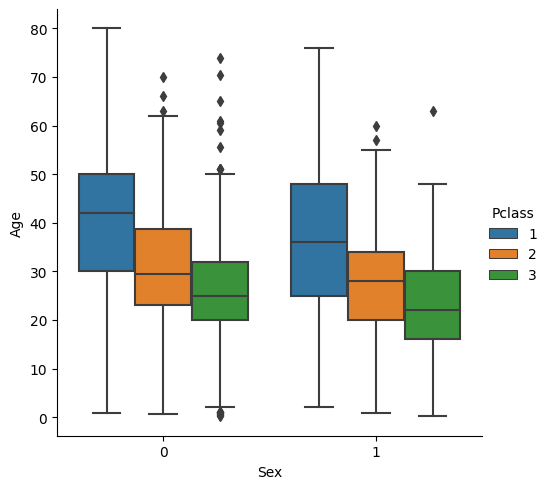

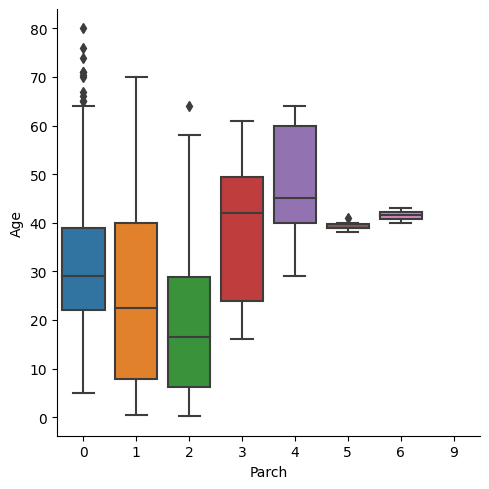

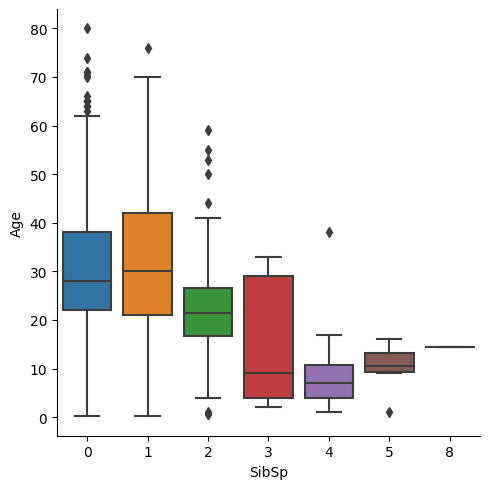

In [288]:
sns.catplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine)

<Axes: >

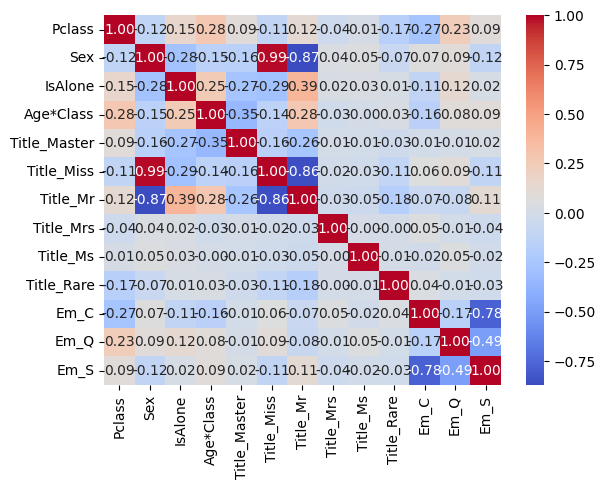

In [366]:
sns.heatmap(combine.drop(['Survived', 'PassengerId', 'Age', 'Fare'], axis = 1).corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

In [296]:
# Check number of missing ages 

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

In [297]:
# Loop through list and inpute missing ages

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp']) 
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [298]:
# Make sure there is no more missing ages 

combine['Age'].isnull().sum()

0

Text(0.5, 1.0, 'Passenger Fare Distribution')

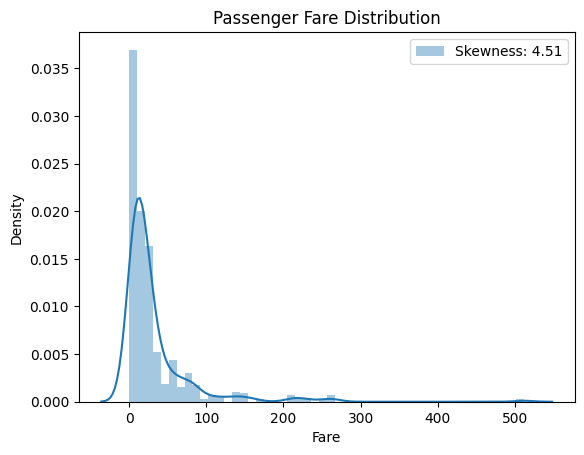

In [299]:
# Passenger fare distribution

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [300]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

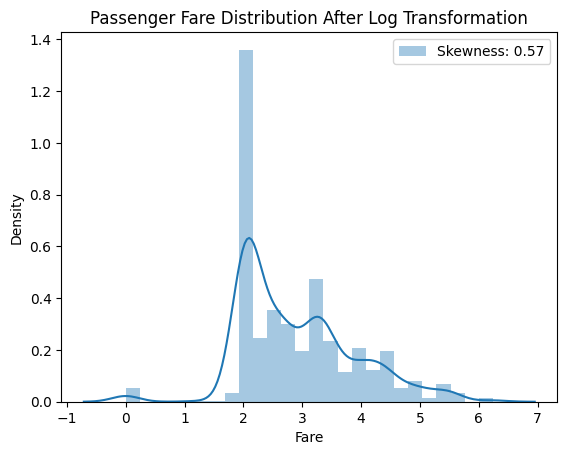

In [301]:
# Passenger fare distribution after log transformation

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

In [302]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,S


In [303]:
# Get title from name

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [304]:
# Value counts of Title

combine['Title'].value_counts()

Title
Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [305]:
# Number of unique Title

combine['Title'].nunique()

18

In [306]:
# Simplify title

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle','Mrs'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

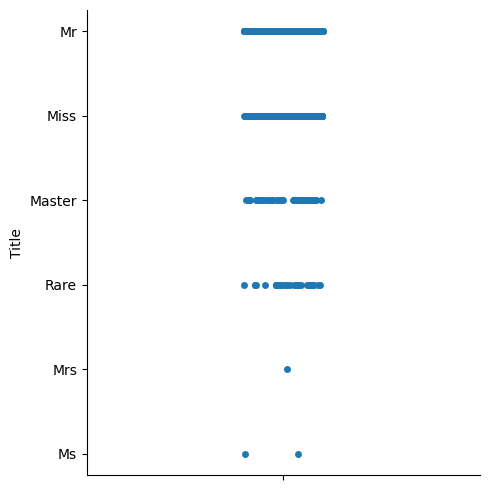

In [307]:
sns.catplot(combine['Title'])

In [308]:
# Mean of survival by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,1.000000
4,Ms,1.000000
1,Miss,0.743421
0,Master,0.589744
5,Rare,0.347826
2,Mr,0.157895


Text(0.5, 1.0, 'Mean of survival by Title')

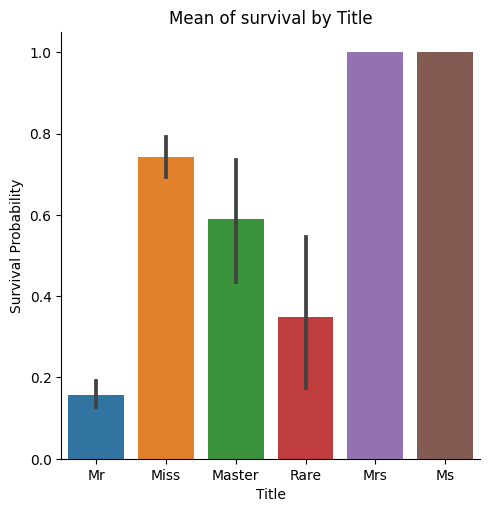

In [309]:
sns.catplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [310]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Miss
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,Miss
4,5,0.0,3,0,35.0,0,0,2.085672,S,Mr


In [311]:
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [312]:
# Mean of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [313]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [314]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [315]:
# Drop SibSp, Parch and FamilySize features from combine dataframe

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,Miss,0
2,3,1.0,3,1,26.0,2.070022,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,Miss,0
4,5,0.0,3,0,35.0,2.085672,S,Mr,1


In [316]:
# Create age bands and compute mean of survival by age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [317]:
# Assign ordinals to each age band 

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [318]:
# Drop age band feature

combine = combine.drop('AgeBand', axis = 1)
# Age and Pclass data types 

combine[['Age', 'Pclass']].dtypes

Age       float64
Pclass      int64
dtype: object

In [319]:
# Convert ordinal Age into integer

combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype


dtype('int32')

In [320]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


In [321]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,1,0.0,3,0,1,1.981001,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,C,Miss,0,2
2,3,1.0,3,1,1,2.070022,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,S,Miss,0,2
4,5,0.0,3,0,2,2.085672,S,Mr,1,6


In [322]:
# Encode Title and Embarked feature

combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,False,False,True,False,False,False,False,False,True
1,2,1.0,1,1,2,4.266662,0,2,False,True,False,False,False,False,True,False,False
2,3,1.0,3,1,1,2.070022,1,3,False,True,False,False,False,False,False,False,True
3,4,1.0,1,1,2,3.972177,0,2,False,True,False,False,False,False,False,False,True
4,5,0.0,3,0,2,2.085672,1,6,False,False,True,False,False,False,False,False,True


In [323]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [324]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [325]:
# Convert Fare into integer

combine['Fare'] = combine['Fare'].astype('int')
# Drop FareBand feature

combine = combine.drop('FareBand', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,2,1.0,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,3,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,4,1.0,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,5,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [326]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,2,1.0,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,3,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,4,1.0,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,5,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [327]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,1.0,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,1.0,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [328]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,1,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,1,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,1,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [329]:
test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
881,892,NaN,3,0,2,1,1,6,False,False,True,False,False,False,False,True,False
882,893,NaN,3,1,2,1,0,6,False,True,False,False,False,False,False,False,True
883,894,NaN,2,0,3,1,1,6,False,False,True,False,False,False,False,True,False
884,895,NaN,3,0,1,1,1,3,False,False,True,False,False,False,False,False,True
885,896,NaN,3,1,1,1,0,3,False,True,False,False,False,False,False,False,True


In [330]:
# Drop passenger survived column from test set

test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
881,892,3,0,2,1,1,6,False,False,True,False,False,False,False,True,False
882,893,3,1,2,1,0,6,False,True,False,False,False,False,False,False,True
883,894,2,0,3,1,1,6,False,False,True,False,False,False,False,True,False
884,895,3,0,1,1,1,3,False,False,True,False,False,False,False,False,True
885,896,3,1,1,1,0,3,False,True,False,False,False,False,False,False,True


In [331]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 15)
Y_train shape:  (881,)
X_test shape:  (418, 15)


In [332]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.93

In [333]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.31

In [334]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.11

In [335]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

61.63

In [336]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.77

In [337]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.14

In [338]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

76.73

In [339]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.13

In [340]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.13

In [341]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6858616	total: 3.93ms	remaining: 3.92s
1:	learn: 0.6794489	total: 8ms	remaining: 3.99s
2:	learn: 0.6734253	total: 11.8ms	remaining: 3.93s
3:	learn: 0.6679846	total: 15.5ms	remaining: 3.86s
4:	learn: 0.6626666	total: 19ms	remaining: 3.78s
5:	learn: 0.6575581	total: 22.9ms	remaining: 3.79s
6:	learn: 0.6515583	total: 26.2ms	remaining: 3.72s
7:	learn: 0.6453888	total: 29.7ms	remaining: 3.68s
8:	learn: 0.6400033	total: 33.2ms	remaining: 3.66s
9:	learn: 0.6340809	total: 36.9ms	remaining: 3.65s
10:	learn: 0.6292482	total: 40.4ms	remaining: 3.63s
11:	learn: 0.6233883	total: 44ms	remaining: 3.62s
12:	learn: 0.6177923	total: 47.6ms	remaining: 3.62s
13:	learn: 0.6129961	total: 51.7ms	remaining: 3.64s
14:	learn: 0.6075451	total: 55.1ms	remaining: 3.62s
15:	learn: 0.6037752	total: 58.5ms	remaining: 3.6s
16:	learn: 0.5998291	total: 62ms	remaining: 3.58s
17:	learn: 0.5954977	total: 65.1ms	remaining: 3.55s
18:	learn: 0.5909803	total: 68.7ms	remaining: 3.55s
19:

173:	learn: 0.3908830	total: 558ms	remaining: 2.65s
174:	learn: 0.3904995	total: 562ms	remaining: 2.65s
175:	learn: 0.3901877	total: 565ms	remaining: 2.64s
176:	learn: 0.3898887	total: 568ms	remaining: 2.64s
177:	learn: 0.3896268	total: 571ms	remaining: 2.64s
178:	learn: 0.3892697	total: 575ms	remaining: 2.64s
179:	learn: 0.3889771	total: 579ms	remaining: 2.63s
180:	learn: 0.3887248	total: 582ms	remaining: 2.63s
181:	learn: 0.3886152	total: 585ms	remaining: 2.63s
182:	learn: 0.3883805	total: 589ms	remaining: 2.63s
183:	learn: 0.3879005	total: 593ms	remaining: 2.63s
184:	learn: 0.3875204	total: 597ms	remaining: 2.63s
185:	learn: 0.3872486	total: 600ms	remaining: 2.63s
186:	learn: 0.3870001	total: 603ms	remaining: 2.62s
187:	learn: 0.3867466	total: 607ms	remaining: 2.62s
188:	learn: 0.3865344	total: 610ms	remaining: 2.62s
189:	learn: 0.3864182	total: 613ms	remaining: 2.61s
190:	learn: 0.3862226	total: 616ms	remaining: 2.61s
191:	learn: 0.3860431	total: 619ms	remaining: 2.6s
192:	learn: 0

358:	learn: 0.3650705	total: 1.12s	remaining: 2s
359:	learn: 0.3650330	total: 1.13s	remaining: 2s
360:	learn: 0.3649928	total: 1.13s	remaining: 2s
361:	learn: 0.3649295	total: 1.13s	remaining: 2s
362:	learn: 0.3649146	total: 1.14s	remaining: 1.99s
363:	learn: 0.3648778	total: 1.14s	remaining: 1.99s
364:	learn: 0.3647798	total: 1.14s	remaining: 1.99s
365:	learn: 0.3647198	total: 1.15s	remaining: 1.99s
366:	learn: 0.3646563	total: 1.15s	remaining: 1.98s
367:	learn: 0.3645618	total: 1.15s	remaining: 1.98s
368:	learn: 0.3645104	total: 1.16s	remaining: 1.98s
369:	learn: 0.3644936	total: 1.16s	remaining: 1.98s
370:	learn: 0.3643357	total: 1.17s	remaining: 1.98s
371:	learn: 0.3642564	total: 1.17s	remaining: 1.97s
372:	learn: 0.3642433	total: 1.17s	remaining: 1.97s
373:	learn: 0.3642048	total: 1.18s	remaining: 1.97s
374:	learn: 0.3641649	total: 1.18s	remaining: 1.96s
375:	learn: 0.3640476	total: 1.18s	remaining: 1.96s
376:	learn: 0.3638973	total: 1.19s	remaining: 1.96s
377:	learn: 0.3638074	to

541:	learn: 0.3546816	total: 1.67s	remaining: 1.41s
542:	learn: 0.3546197	total: 1.68s	remaining: 1.41s
543:	learn: 0.3545379	total: 1.68s	remaining: 1.41s
544:	learn: 0.3544171	total: 1.68s	remaining: 1.41s
545:	learn: 0.3543901	total: 1.69s	remaining: 1.4s
546:	learn: 0.3543820	total: 1.69s	remaining: 1.4s
547:	learn: 0.3543791	total: 1.69s	remaining: 1.4s
548:	learn: 0.3543226	total: 1.7s	remaining: 1.39s
549:	learn: 0.3542810	total: 1.7s	remaining: 1.39s
550:	learn: 0.3542119	total: 1.7s	remaining: 1.39s
551:	learn: 0.3541785	total: 1.71s	remaining: 1.39s
552:	learn: 0.3541440	total: 1.71s	remaining: 1.38s
553:	learn: 0.3541112	total: 1.71s	remaining: 1.38s
554:	learn: 0.3540635	total: 1.72s	remaining: 1.38s
555:	learn: 0.3539860	total: 1.72s	remaining: 1.37s
556:	learn: 0.3539459	total: 1.72s	remaining: 1.37s
557:	learn: 0.3539165	total: 1.72s	remaining: 1.37s
558:	learn: 0.3538722	total: 1.73s	remaining: 1.36s
559:	learn: 0.3538378	total: 1.73s	remaining: 1.36s
560:	learn: 0.3538

736:	learn: 0.3466143	total: 2.23s	remaining: 795ms
737:	learn: 0.3465451	total: 2.23s	remaining: 793ms
738:	learn: 0.3465032	total: 2.23s	remaining: 790ms
739:	learn: 0.3464723	total: 2.24s	remaining: 787ms
740:	learn: 0.3464283	total: 2.24s	remaining: 784ms
741:	learn: 0.3464141	total: 2.25s	remaining: 781ms
742:	learn: 0.3464065	total: 2.25s	remaining: 777ms
743:	learn: 0.3464047	total: 2.25s	remaining: 774ms
744:	learn: 0.3463957	total: 2.25s	remaining: 772ms
745:	learn: 0.3463949	total: 2.26s	remaining: 768ms
746:	learn: 0.3463530	total: 2.26s	remaining: 765ms
747:	learn: 0.3463342	total: 2.26s	remaining: 763ms
748:	learn: 0.3462733	total: 2.27s	remaining: 760ms
749:	learn: 0.3462529	total: 2.27s	remaining: 757ms
750:	learn: 0.3462523	total: 2.27s	remaining: 753ms
751:	learn: 0.3462205	total: 2.27s	remaining: 750ms
752:	learn: 0.3461642	total: 2.28s	remaining: 747ms
753:	learn: 0.3461345	total: 2.28s	remaining: 744ms
754:	learn: 0.3461006	total: 2.28s	remaining: 741ms
755:	learn: 

931:	learn: 0.3404163	total: 2.79s	remaining: 203ms
932:	learn: 0.3403907	total: 2.79s	remaining: 200ms
933:	learn: 0.3403689	total: 2.79s	remaining: 197ms
934:	learn: 0.3402980	total: 2.8s	remaining: 194ms
935:	learn: 0.3402613	total: 2.8s	remaining: 191ms
936:	learn: 0.3402371	total: 2.8s	remaining: 189ms
937:	learn: 0.3402252	total: 2.81s	remaining: 186ms
938:	learn: 0.3401797	total: 2.81s	remaining: 183ms
939:	learn: 0.3401502	total: 2.81s	remaining: 180ms
940:	learn: 0.3401249	total: 2.82s	remaining: 177ms
941:	learn: 0.3401064	total: 2.82s	remaining: 174ms
942:	learn: 0.3400855	total: 2.82s	remaining: 171ms
943:	learn: 0.3400624	total: 2.83s	remaining: 168ms
944:	learn: 0.3400503	total: 2.83s	remaining: 165ms
945:	learn: 0.3400327	total: 2.83s	remaining: 162ms
946:	learn: 0.3400228	total: 2.84s	remaining: 159ms
947:	learn: 0.3399921	total: 2.84s	remaining: 156ms
948:	learn: 0.3399661	total: 2.84s	remaining: 153ms
949:	learn: 0.3399624	total: 2.85s	remaining: 150ms
950:	learn: 0.3

In [342]:
acc_catboost

85.02

In [343]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,85.13
1,Decision Tree,85.13
2,CatBoost,85.02
3,KNN,84.11
4,Support Vector Machines,83.31
5,Logistic Regression,80.93
6,Linear SVC,80.14
7,Perceptron,78.77
8,Stochastic Gradient Decent,76.73
9,Naive Bayes,61.63


In [344]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [345]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009326
0:	learn: 0.6860947	total: 3.1ms	remaining: 3.1s
1:	learn: 0.6802154	total: 6.05ms	remaining: 3.02s
2:	learn: 0.6735760	total: 8.83ms	remaining: 2.93s
3:	learn: 0.6678713	total: 11.7ms	remaining: 2.9s
4:	learn: 0.6623104	total: 14.5ms	remaining: 2.89s
5:	learn: 0.6573463	total: 17.2ms	remaining: 2.85s
6:	learn: 0.6520895	total: 19.8ms	remaining: 2.81s
7:	learn: 0.6470688	total: 22.4ms	remaining: 2.78s
8:	learn: 0.6439155	total: 24.5ms	remaining: 2.7s
9:	learn: 0.6389356	total: 27.2ms	remaining: 2.7s
10:	learn: 0.6331751	total: 30ms	remaining: 2.7s
11:	learn: 0.6280368	total: 32.7ms	remaining: 2.7s
12:	learn: 0.6236099	total: 35.2ms	remaining: 2.67s
13:	learn: 0.6186777	total: 38ms	remaining: 2.67s
14:	learn: 0.6138725	total: 40.7ms	remaining: 2.67s
15:	learn: 0.6110885	total: 42.8ms	remaining: 2.63s
16:	learn: 0.6059912	total: 45.6ms	remaining: 2.63s
17:	learn: 0.6026544	total: 47.6ms	remaining: 2.6s
18:	learn: 0.6001507	total: 49.7ms	remaining: 2.56s
19:	

167:	learn: 0.3899851	total: 533ms	remaining: 2.64s
168:	learn: 0.3899378	total: 536ms	remaining: 2.63s
169:	learn: 0.3896148	total: 539ms	remaining: 2.63s
170:	learn: 0.3893424	total: 542ms	remaining: 2.63s
171:	learn: 0.3890601	total: 545ms	remaining: 2.63s
172:	learn: 0.3886941	total: 549ms	remaining: 2.62s
173:	learn: 0.3885647	total: 551ms	remaining: 2.62s
174:	learn: 0.3882535	total: 554ms	remaining: 2.61s
175:	learn: 0.3878691	total: 558ms	remaining: 2.61s
176:	learn: 0.3877141	total: 561ms	remaining: 2.61s
177:	learn: 0.3874227	total: 565ms	remaining: 2.61s
178:	learn: 0.3871335	total: 569ms	remaining: 2.61s
179:	learn: 0.3868254	total: 572ms	remaining: 2.6s
180:	learn: 0.3864773	total: 575ms	remaining: 2.6s
181:	learn: 0.3862346	total: 579ms	remaining: 2.6s
182:	learn: 0.3857666	total: 582ms	remaining: 2.6s
183:	learn: 0.3853910	total: 585ms	remaining: 2.6s
184:	learn: 0.3852351	total: 588ms	remaining: 2.59s
185:	learn: 0.3850202	total: 591ms	remaining: 2.58s
186:	learn: 0.384

368:	learn: 0.3601599	total: 1.11s	remaining: 1.89s
369:	learn: 0.3600495	total: 1.11s	remaining: 1.89s
370:	learn: 0.3600271	total: 1.11s	remaining: 1.89s
371:	learn: 0.3599728	total: 1.12s	remaining: 1.89s
372:	learn: 0.3598716	total: 1.12s	remaining: 1.88s
373:	learn: 0.3597992	total: 1.12s	remaining: 1.88s
374:	learn: 0.3597353	total: 1.13s	remaining: 1.88s
375:	learn: 0.3596722	total: 1.13s	remaining: 1.88s
376:	learn: 0.3595726	total: 1.13s	remaining: 1.87s
377:	learn: 0.3594873	total: 1.14s	remaining: 1.87s
378:	learn: 0.3594463	total: 1.14s	remaining: 1.87s
379:	learn: 0.3594070	total: 1.14s	remaining: 1.87s
380:	learn: 0.3593414	total: 1.15s	remaining: 1.86s
381:	learn: 0.3592343	total: 1.15s	remaining: 1.86s
382:	learn: 0.3592283	total: 1.15s	remaining: 1.86s
383:	learn: 0.3591979	total: 1.16s	remaining: 1.85s
384:	learn: 0.3591087	total: 1.16s	remaining: 1.85s
385:	learn: 0.3590190	total: 1.16s	remaining: 1.85s
386:	learn: 0.3589407	total: 1.17s	remaining: 1.84s
387:	learn: 

564:	learn: 0.3480380	total: 1.66s	remaining: 1.28s
565:	learn: 0.3479529	total: 1.66s	remaining: 1.28s
566:	learn: 0.3479369	total: 1.67s	remaining: 1.27s
567:	learn: 0.3478826	total: 1.67s	remaining: 1.27s
568:	learn: 0.3478188	total: 1.67s	remaining: 1.27s
569:	learn: 0.3477461	total: 1.68s	remaining: 1.26s
570:	learn: 0.3476843	total: 1.68s	remaining: 1.26s
571:	learn: 0.3476537	total: 1.68s	remaining: 1.26s
572:	learn: 0.3476433	total: 1.69s	remaining: 1.26s
573:	learn: 0.3475939	total: 1.69s	remaining: 1.25s
574:	learn: 0.3475539	total: 1.69s	remaining: 1.25s
575:	learn: 0.3475202	total: 1.7s	remaining: 1.25s
576:	learn: 0.3475048	total: 1.7s	remaining: 1.25s
577:	learn: 0.3474646	total: 1.7s	remaining: 1.24s
578:	learn: 0.3474255	total: 1.71s	remaining: 1.24s
579:	learn: 0.3473794	total: 1.71s	remaining: 1.24s
580:	learn: 0.3473767	total: 1.71s	remaining: 1.23s
581:	learn: 0.3472414	total: 1.72s	remaining: 1.23s
582:	learn: 0.3470880	total: 1.72s	remaining: 1.23s
583:	learn: 0.3

768:	learn: 0.3395004	total: 2.23s	remaining: 670ms
769:	learn: 0.3394375	total: 2.23s	remaining: 667ms
770:	learn: 0.3393814	total: 2.24s	remaining: 665ms
771:	learn: 0.3393643	total: 2.24s	remaining: 662ms
772:	learn: 0.3393045	total: 2.24s	remaining: 659ms
773:	learn: 0.3392226	total: 2.25s	remaining: 656ms
774:	learn: 0.3392110	total: 2.25s	remaining: 653ms
775:	learn: 0.3391759	total: 2.25s	remaining: 650ms
776:	learn: 0.3391552	total: 2.26s	remaining: 648ms
777:	learn: 0.3390866	total: 2.26s	remaining: 645ms
778:	learn: 0.3390557	total: 2.26s	remaining: 642ms
779:	learn: 0.3390225	total: 2.27s	remaining: 639ms
780:	learn: 0.3389653	total: 2.27s	remaining: 637ms
781:	learn: 0.3389534	total: 2.27s	remaining: 634ms
782:	learn: 0.3388568	total: 2.28s	remaining: 631ms
783:	learn: 0.3387829	total: 2.28s	remaining: 628ms
784:	learn: 0.3387106	total: 2.28s	remaining: 625ms
785:	learn: 0.3386888	total: 2.29s	remaining: 622ms
786:	learn: 0.3386552	total: 2.29s	remaining: 619ms
787:	learn: 

961:	learn: 0.3326648	total: 2.79s	remaining: 110ms
962:	learn: 0.3326257	total: 2.79s	remaining: 107ms
963:	learn: 0.3326199	total: 2.8s	remaining: 104ms
964:	learn: 0.3325793	total: 2.8s	remaining: 102ms
965:	learn: 0.3325606	total: 2.8s	remaining: 98.7ms
966:	learn: 0.3325423	total: 2.81s	remaining: 95.8ms
967:	learn: 0.3324620	total: 2.81s	remaining: 92.9ms
968:	learn: 0.3324500	total: 2.81s	remaining: 90ms
969:	learn: 0.3324248	total: 2.82s	remaining: 87.1ms
970:	learn: 0.3323908	total: 2.82s	remaining: 84.2ms
971:	learn: 0.3323444	total: 2.82s	remaining: 81.3ms
972:	learn: 0.3323233	total: 2.83s	remaining: 78.4ms
973:	learn: 0.3322940	total: 2.83s	remaining: 75.5ms
974:	learn: 0.3322765	total: 2.83s	remaining: 72.7ms
975:	learn: 0.3322467	total: 2.84s	remaining: 69.7ms
976:	learn: 0.3322052	total: 2.84s	remaining: 66.8ms
977:	learn: 0.3321811	total: 2.84s	remaining: 63.9ms
978:	learn: 0.3321299	total: 2.85s	remaining: 61ms
979:	learn: 0.3320938	total: 2.85s	remaining: 58.1ms
980:

130:	learn: 0.4135041	total: 365ms	remaining: 2.42s
131:	learn: 0.4127866	total: 369ms	remaining: 2.42s
132:	learn: 0.4126094	total: 371ms	remaining: 2.42s
133:	learn: 0.4120552	total: 375ms	remaining: 2.42s
134:	learn: 0.4116861	total: 377ms	remaining: 2.42s
135:	learn: 0.4112530	total: 380ms	remaining: 2.42s
136:	learn: 0.4106167	total: 383ms	remaining: 2.42s
137:	learn: 0.4101288	total: 387ms	remaining: 2.42s
138:	learn: 0.4095196	total: 390ms	remaining: 2.42s
139:	learn: 0.4089162	total: 394ms	remaining: 2.42s
140:	learn: 0.4086098	total: 397ms	remaining: 2.42s
141:	learn: 0.4080378	total: 401ms	remaining: 2.42s
142:	learn: 0.4078478	total: 403ms	remaining: 2.42s
143:	learn: 0.4073214	total: 407ms	remaining: 2.42s
144:	learn: 0.4068439	total: 410ms	remaining: 2.42s
145:	learn: 0.4061728	total: 412ms	remaining: 2.41s
146:	learn: 0.4057079	total: 416ms	remaining: 2.41s
147:	learn: 0.4050744	total: 419ms	remaining: 2.41s
148:	learn: 0.4049435	total: 421ms	remaining: 2.4s
149:	learn: 0

328:	learn: 0.3692302	total: 931ms	remaining: 1.9s
329:	learn: 0.3691058	total: 935ms	remaining: 1.9s
330:	learn: 0.3690433	total: 938ms	remaining: 1.9s
331:	learn: 0.3689502	total: 942ms	remaining: 1.89s
332:	learn: 0.3688784	total: 945ms	remaining: 1.89s
333:	learn: 0.3688014	total: 948ms	remaining: 1.89s
334:	learn: 0.3687912	total: 950ms	remaining: 1.89s
335:	learn: 0.3687336	total: 953ms	remaining: 1.88s
336:	learn: 0.3685744	total: 956ms	remaining: 1.88s
337:	learn: 0.3684367	total: 960ms	remaining: 1.88s
338:	learn: 0.3683504	total: 963ms	remaining: 1.88s
339:	learn: 0.3683131	total: 966ms	remaining: 1.88s
340:	learn: 0.3681469	total: 970ms	remaining: 1.87s
341:	learn: 0.3680784	total: 973ms	remaining: 1.87s
342:	learn: 0.3680295	total: 976ms	remaining: 1.87s
343:	learn: 0.3679557	total: 979ms	remaining: 1.87s
344:	learn: 0.3679182	total: 982ms	remaining: 1.86s
345:	learn: 0.3678477	total: 985ms	remaining: 1.86s
346:	learn: 0.3678255	total: 987ms	remaining: 1.86s
347:	learn: 0.3

523:	learn: 0.3567142	total: 1.49s	remaining: 1.35s
524:	learn: 0.3565938	total: 1.49s	remaining: 1.35s
525:	learn: 0.3565683	total: 1.5s	remaining: 1.35s
526:	learn: 0.3565544	total: 1.5s	remaining: 1.34s
527:	learn: 0.3565467	total: 1.5s	remaining: 1.34s
528:	learn: 0.3565060	total: 1.5s	remaining: 1.34s
529:	learn: 0.3564356	total: 1.51s	remaining: 1.34s
530:	learn: 0.3563832	total: 1.51s	remaining: 1.33s
531:	learn: 0.3563594	total: 1.51s	remaining: 1.33s
532:	learn: 0.3562912	total: 1.52s	remaining: 1.33s
533:	learn: 0.3562673	total: 1.52s	remaining: 1.33s
534:	learn: 0.3562018	total: 1.52s	remaining: 1.32s
535:	learn: 0.3561466	total: 1.53s	remaining: 1.32s
536:	learn: 0.3560623	total: 1.53s	remaining: 1.32s
537:	learn: 0.3559893	total: 1.53s	remaining: 1.32s
538:	learn: 0.3559005	total: 1.54s	remaining: 1.31s
539:	learn: 0.3558711	total: 1.54s	remaining: 1.31s
540:	learn: 0.3557920	total: 1.54s	remaining: 1.31s
541:	learn: 0.3557455	total: 1.54s	remaining: 1.31s
542:	learn: 0.35

722:	learn: 0.3475643	total: 2.05s	remaining: 785ms
723:	learn: 0.3475505	total: 2.05s	remaining: 782ms
724:	learn: 0.3475472	total: 2.05s	remaining: 779ms
725:	learn: 0.3475174	total: 2.06s	remaining: 777ms
726:	learn: 0.3474953	total: 2.06s	remaining: 774ms
727:	learn: 0.3474732	total: 2.06s	remaining: 771ms
728:	learn: 0.3474269	total: 2.07s	remaining: 768ms
729:	learn: 0.3473934	total: 2.07s	remaining: 766ms
730:	learn: 0.3473422	total: 2.07s	remaining: 763ms
731:	learn: 0.3473145	total: 2.08s	remaining: 760ms
732:	learn: 0.3472737	total: 2.08s	remaining: 758ms
733:	learn: 0.3472411	total: 2.08s	remaining: 755ms
734:	learn: 0.3471899	total: 2.09s	remaining: 753ms
735:	learn: 0.3471437	total: 2.09s	remaining: 750ms
736:	learn: 0.3471030	total: 2.09s	remaining: 747ms
737:	learn: 0.3470805	total: 2.1s	remaining: 744ms
738:	learn: 0.3470408	total: 2.1s	remaining: 742ms
739:	learn: 0.3469618	total: 2.1s	remaining: 739ms
740:	learn: 0.3469124	total: 2.1s	remaining: 736ms
741:	learn: 0.34

918:	learn: 0.3403286	total: 2.6s	remaining: 229ms
919:	learn: 0.3403046	total: 2.61s	remaining: 227ms
920:	learn: 0.3402808	total: 2.61s	remaining: 224ms
921:	learn: 0.3402645	total: 2.61s	remaining: 221ms
922:	learn: 0.3401954	total: 2.62s	remaining: 218ms
923:	learn: 0.3401547	total: 2.62s	remaining: 215ms
924:	learn: 0.3401238	total: 2.62s	remaining: 213ms
925:	learn: 0.3401088	total: 2.62s	remaining: 210ms
926:	learn: 0.3400884	total: 2.63s	remaining: 207ms
927:	learn: 0.3400418	total: 2.63s	remaining: 204ms
928:	learn: 0.3399969	total: 2.63s	remaining: 201ms
929:	learn: 0.3399610	total: 2.64s	remaining: 199ms
930:	learn: 0.3399420	total: 2.64s	remaining: 196ms
931:	learn: 0.3399155	total: 2.65s	remaining: 193ms
932:	learn: 0.3398295	total: 2.65s	remaining: 190ms
933:	learn: 0.3398178	total: 2.65s	remaining: 187ms
934:	learn: 0.3397913	total: 2.65s	remaining: 185ms
935:	learn: 0.3397665	total: 2.66s	remaining: 182ms
936:	learn: 0.3397209	total: 2.66s	remaining: 179ms
937:	learn: 0

83:	learn: 0.4289881	total: 240ms	remaining: 2.62s
84:	learn: 0.4278399	total: 244ms	remaining: 2.63s
85:	learn: 0.4272906	total: 247ms	remaining: 2.62s
86:	learn: 0.4260665	total: 250ms	remaining: 2.62s
87:	learn: 0.4250242	total: 253ms	remaining: 2.62s
88:	learn: 0.4241298	total: 256ms	remaining: 2.62s
89:	learn: 0.4229516	total: 259ms	remaining: 2.62s
90:	learn: 0.4222743	total: 262ms	remaining: 2.62s
91:	learn: 0.4213831	total: 266ms	remaining: 2.62s
92:	learn: 0.4201769	total: 269ms	remaining: 2.63s
93:	learn: 0.4187957	total: 273ms	remaining: 2.63s
94:	learn: 0.4173140	total: 277ms	remaining: 2.63s
95:	learn: 0.4163331	total: 280ms	remaining: 2.64s
96:	learn: 0.4151369	total: 283ms	remaining: 2.64s
97:	learn: 0.4147545	total: 285ms	remaining: 2.63s
98:	learn: 0.4135232	total: 288ms	remaining: 2.62s
99:	learn: 0.4122539	total: 292ms	remaining: 2.63s
100:	learn: 0.4115695	total: 295ms	remaining: 2.63s
101:	learn: 0.4105406	total: 298ms	remaining: 2.62s
102:	learn: 0.4095612	total: 

277:	learn: 0.3503366	total: 798ms	remaining: 2.07s
278:	learn: 0.3501961	total: 802ms	remaining: 2.07s
279:	learn: 0.3501791	total: 805ms	remaining: 2.07s
280:	learn: 0.3500908	total: 808ms	remaining: 2.07s
281:	learn: 0.3498689	total: 811ms	remaining: 2.06s
282:	learn: 0.3497787	total: 814ms	remaining: 2.06s
283:	learn: 0.3496704	total: 817ms	remaining: 2.06s
284:	learn: 0.3495428	total: 821ms	remaining: 2.06s
285:	learn: 0.3493663	total: 824ms	remaining: 2.06s
286:	learn: 0.3493213	total: 827ms	remaining: 2.06s
287:	learn: 0.3492284	total: 831ms	remaining: 2.05s
288:	learn: 0.3492108	total: 834ms	remaining: 2.05s
289:	learn: 0.3491243	total: 837ms	remaining: 2.05s
290:	learn: 0.3488542	total: 841ms	remaining: 2.05s
291:	learn: 0.3488239	total: 844ms	remaining: 2.04s
292:	learn: 0.3486897	total: 847ms	remaining: 2.04s
293:	learn: 0.3484832	total: 851ms	remaining: 2.04s
294:	learn: 0.3484239	total: 854ms	remaining: 2.04s
295:	learn: 0.3482185	total: 857ms	remaining: 2.04s
296:	learn: 

474:	learn: 0.3350047	total: 1.35s	remaining: 1.5s
475:	learn: 0.3349116	total: 1.36s	remaining: 1.49s
476:	learn: 0.3348565	total: 1.36s	remaining: 1.49s
477:	learn: 0.3348250	total: 1.36s	remaining: 1.49s
478:	learn: 0.3347177	total: 1.36s	remaining: 1.49s
479:	learn: 0.3346782	total: 1.37s	remaining: 1.48s
480:	learn: 0.3346393	total: 1.37s	remaining: 1.48s
481:	learn: 0.3345863	total: 1.38s	remaining: 1.48s
482:	learn: 0.3344890	total: 1.38s	remaining: 1.48s
483:	learn: 0.3344765	total: 1.38s	remaining: 1.47s
484:	learn: 0.3344189	total: 1.39s	remaining: 1.47s
485:	learn: 0.3343635	total: 1.39s	remaining: 1.47s
486:	learn: 0.3342832	total: 1.39s	remaining: 1.47s
487:	learn: 0.3342355	total: 1.4s	remaining: 1.46s
488:	learn: 0.3342116	total: 1.4s	remaining: 1.46s
489:	learn: 0.3342028	total: 1.4s	remaining: 1.46s
490:	learn: 0.3341594	total: 1.4s	remaining: 1.45s
491:	learn: 0.3340981	total: 1.41s	remaining: 1.45s
492:	learn: 0.3340603	total: 1.41s	remaining: 1.45s
493:	learn: 0.333

667:	learn: 0.3270204	total: 1.89s	remaining: 940ms
668:	learn: 0.3269863	total: 1.9s	remaining: 938ms
669:	learn: 0.3269675	total: 1.9s	remaining: 935ms
670:	learn: 0.3269595	total: 1.9s	remaining: 933ms
671:	learn: 0.3269536	total: 1.9s	remaining: 930ms
672:	learn: 0.3269293	total: 1.91s	remaining: 927ms
673:	learn: 0.3268344	total: 1.91s	remaining: 924ms
674:	learn: 0.3267872	total: 1.91s	remaining: 922ms
675:	learn: 0.3267598	total: 1.92s	remaining: 919ms
676:	learn: 0.3267261	total: 1.92s	remaining: 917ms
677:	learn: 0.3267209	total: 1.92s	remaining: 914ms
678:	learn: 0.3266625	total: 1.93s	remaining: 912ms
679:	learn: 0.3265681	total: 1.93s	remaining: 909ms
680:	learn: 0.3265285	total: 1.94s	remaining: 907ms
681:	learn: 0.3265095	total: 1.94s	remaining: 904ms
682:	learn: 0.3264575	total: 1.94s	remaining: 901ms
683:	learn: 0.3264540	total: 1.94s	remaining: 898ms
684:	learn: 0.3264420	total: 1.95s	remaining: 895ms
685:	learn: 0.3263923	total: 1.95s	remaining: 892ms
686:	learn: 0.32

862:	learn: 0.3197003	total: 2.45s	remaining: 389ms
863:	learn: 0.3196733	total: 2.45s	remaining: 386ms
864:	learn: 0.3196510	total: 2.46s	remaining: 383ms
865:	learn: 0.3196341	total: 2.46s	remaining: 380ms
866:	learn: 0.3196132	total: 2.46s	remaining: 378ms
867:	learn: 0.3195857	total: 2.46s	remaining: 375ms
868:	learn: 0.3195583	total: 2.47s	remaining: 372ms
869:	learn: 0.3195565	total: 2.47s	remaining: 369ms
870:	learn: 0.3195172	total: 2.47s	remaining: 366ms
871:	learn: 0.3194569	total: 2.48s	remaining: 364ms
872:	learn: 0.3194108	total: 2.48s	remaining: 361ms
873:	learn: 0.3193543	total: 2.48s	remaining: 358ms
874:	learn: 0.3192713	total: 2.49s	remaining: 355ms
875:	learn: 0.3191966	total: 2.49s	remaining: 353ms
876:	learn: 0.3191610	total: 2.49s	remaining: 350ms
877:	learn: 0.3191291	total: 2.5s	remaining: 347ms
878:	learn: 0.3191287	total: 2.5s	remaining: 344ms
879:	learn: 0.3190861	total: 2.5s	remaining: 341ms
880:	learn: 0.3190600	total: 2.5s	remaining: 338ms
881:	learn: 0.31

28:	learn: 0.5592063	total: 80.7ms	remaining: 2.7s
29:	learn: 0.5560546	total: 84.5ms	remaining: 2.73s
30:	learn: 0.5528789	total: 87.8ms	remaining: 2.75s
31:	learn: 0.5505096	total: 90.5ms	remaining: 2.74s
32:	learn: 0.5477021	total: 93.5ms	remaining: 2.74s
33:	learn: 0.5462701	total: 95.8ms	remaining: 2.72s
34:	learn: 0.5432840	total: 99ms	remaining: 2.73s
35:	learn: 0.5418223	total: 102ms	remaining: 2.72s
36:	learn: 0.5396529	total: 105ms	remaining: 2.73s
37:	learn: 0.5369212	total: 108ms	remaining: 2.74s
38:	learn: 0.5336607	total: 113ms	remaining: 2.78s
39:	learn: 0.5307819	total: 116ms	remaining: 2.79s
40:	learn: 0.5283903	total: 120ms	remaining: 2.81s
41:	learn: 0.5260183	total: 123ms	remaining: 2.8s
42:	learn: 0.5230564	total: 126ms	remaining: 2.8s
43:	learn: 0.5210565	total: 128ms	remaining: 2.79s
44:	learn: 0.5182114	total: 132ms	remaining: 2.8s
45:	learn: 0.5156465	total: 135ms	remaining: 2.8s
46:	learn: 0.5135107	total: 138ms	remaining: 2.79s
47:	learn: 0.5111902	total: 140

217:	learn: 0.3855825	total: 645ms	remaining: 2.31s
218:	learn: 0.3854664	total: 649ms	remaining: 2.31s
219:	learn: 0.3852205	total: 652ms	remaining: 2.31s
220:	learn: 0.3850075	total: 656ms	remaining: 2.31s
221:	learn: 0.3847544	total: 659ms	remaining: 2.31s
222:	learn: 0.3844603	total: 662ms	remaining: 2.31s
223:	learn: 0.3844415	total: 665ms	remaining: 2.3s
224:	learn: 0.3842055	total: 668ms	remaining: 2.3s
225:	learn: 0.3840242	total: 672ms	remaining: 2.3s
226:	learn: 0.3837067	total: 675ms	remaining: 2.3s
227:	learn: 0.3836398	total: 678ms	remaining: 2.29s
228:	learn: 0.3834776	total: 681ms	remaining: 2.29s
229:	learn: 0.3832639	total: 685ms	remaining: 2.29s
230:	learn: 0.3831494	total: 688ms	remaining: 2.29s
231:	learn: 0.3831173	total: 691ms	remaining: 2.29s
232:	learn: 0.3830197	total: 694ms	remaining: 2.28s
233:	learn: 0.3827551	total: 697ms	remaining: 2.28s
234:	learn: 0.3825305	total: 704ms	remaining: 2.29s
235:	learn: 0.3823256	total: 708ms	remaining: 2.29s
236:	learn: 0.38

402:	learn: 0.3647296	total: 1.2s	remaining: 1.77s
403:	learn: 0.3646718	total: 1.2s	remaining: 1.77s
404:	learn: 0.3645535	total: 1.21s	remaining: 1.77s
405:	learn: 0.3645411	total: 1.21s	remaining: 1.77s
406:	learn: 0.3644236	total: 1.21s	remaining: 1.76s
407:	learn: 0.3643975	total: 1.21s	remaining: 1.76s
408:	learn: 0.3643694	total: 1.22s	remaining: 1.76s
409:	learn: 0.3642661	total: 1.22s	remaining: 1.76s
410:	learn: 0.3641448	total: 1.22s	remaining: 1.75s
411:	learn: 0.3640681	total: 1.23s	remaining: 1.75s
412:	learn: 0.3639536	total: 1.23s	remaining: 1.75s
413:	learn: 0.3638943	total: 1.23s	remaining: 1.75s
414:	learn: 0.3637516	total: 1.24s	remaining: 1.74s
415:	learn: 0.3636651	total: 1.24s	remaining: 1.74s
416:	learn: 0.3636226	total: 1.24s	remaining: 1.74s
417:	learn: 0.3635730	total: 1.25s	remaining: 1.73s
418:	learn: 0.3635168	total: 1.25s	remaining: 1.73s
419:	learn: 0.3634823	total: 1.25s	remaining: 1.73s
420:	learn: 0.3634034	total: 1.25s	remaining: 1.73s
421:	learn: 0.

603:	learn: 0.3538340	total: 1.75s	remaining: 1.15s
604:	learn: 0.3537794	total: 1.76s	remaining: 1.15s
605:	learn: 0.3536910	total: 1.76s	remaining: 1.15s
606:	learn: 0.3536735	total: 1.76s	remaining: 1.14s
607:	learn: 0.3536087	total: 1.77s	remaining: 1.14s
608:	learn: 0.3535728	total: 1.77s	remaining: 1.14s
609:	learn: 0.3535684	total: 1.77s	remaining: 1.13s
610:	learn: 0.3535273	total: 1.78s	remaining: 1.13s
611:	learn: 0.3534235	total: 1.78s	remaining: 1.13s
612:	learn: 0.3533693	total: 1.78s	remaining: 1.13s
613:	learn: 0.3533271	total: 1.79s	remaining: 1.12s
614:	learn: 0.3532827	total: 1.79s	remaining: 1.12s
615:	learn: 0.3531910	total: 1.79s	remaining: 1.12s
616:	learn: 0.3531589	total: 1.8s	remaining: 1.11s
617:	learn: 0.3531023	total: 1.8s	remaining: 1.11s
618:	learn: 0.3530540	total: 1.8s	remaining: 1.11s
619:	learn: 0.3530172	total: 1.8s	remaining: 1.11s
620:	learn: 0.3529350	total: 1.81s	remaining: 1.1s
621:	learn: 0.3528816	total: 1.81s	remaining: 1.1s
622:	learn: 0.3528

766:	learn: 0.3471463	total: 2.32s	remaining: 704ms
767:	learn: 0.3471239	total: 2.32s	remaining: 701ms
768:	learn: 0.3470775	total: 2.32s	remaining: 698ms
769:	learn: 0.3470726	total: 2.33s	remaining: 695ms
770:	learn: 0.3470499	total: 2.33s	remaining: 692ms
771:	learn: 0.3470438	total: 2.33s	remaining: 689ms
772:	learn: 0.3470109	total: 2.34s	remaining: 686ms
773:	learn: 0.3469802	total: 2.34s	remaining: 683ms
774:	learn: 0.3469171	total: 2.34s	remaining: 681ms
775:	learn: 0.3468487	total: 2.35s	remaining: 678ms
776:	learn: 0.3468057	total: 2.35s	remaining: 675ms
777:	learn: 0.3467190	total: 2.35s	remaining: 672ms
778:	learn: 0.3466719	total: 2.36s	remaining: 669ms
779:	learn: 0.3466193	total: 2.36s	remaining: 666ms
780:	learn: 0.3465550	total: 2.36s	remaining: 663ms
781:	learn: 0.3465268	total: 2.37s	remaining: 660ms
782:	learn: 0.3465079	total: 2.37s	remaining: 656ms
783:	learn: 0.3464578	total: 2.37s	remaining: 653ms
784:	learn: 0.3464192	total: 2.37s	remaining: 650ms
785:	learn: 

957:	learn: 0.3400884	total: 2.87s	remaining: 126ms
958:	learn: 0.3400528	total: 2.87s	remaining: 123ms
959:	learn: 0.3400462	total: 2.88s	remaining: 120ms
960:	learn: 0.3400174	total: 2.88s	remaining: 117ms
961:	learn: 0.3400037	total: 2.88s	remaining: 114ms
962:	learn: 0.3399602	total: 2.88s	remaining: 111ms
963:	learn: 0.3399146	total: 2.89s	remaining: 108ms
964:	learn: 0.3398892	total: 2.89s	remaining: 105ms
965:	learn: 0.3398516	total: 2.9s	remaining: 102ms
966:	learn: 0.3398498	total: 2.9s	remaining: 98.9ms
967:	learn: 0.3398431	total: 2.9s	remaining: 95.9ms
968:	learn: 0.3398045	total: 2.9s	remaining: 92.9ms
969:	learn: 0.3397611	total: 2.91s	remaining: 89.9ms
970:	learn: 0.3397296	total: 2.91s	remaining: 86.9ms
971:	learn: 0.3397150	total: 2.91s	remaining: 83.9ms
972:	learn: 0.3396957	total: 2.92s	remaining: 80.9ms
973:	learn: 0.3396478	total: 2.92s	remaining: 77.9ms
974:	learn: 0.3396467	total: 2.92s	remaining: 74.9ms
975:	learn: 0.3396196	total: 2.92s	remaining: 71.9ms
976:	l

132:	learn: 0.4117111	total: 367ms	remaining: 2.39s
133:	learn: 0.4112278	total: 371ms	remaining: 2.4s
134:	learn: 0.4107257	total: 375ms	remaining: 2.4s
135:	learn: 0.4102402	total: 378ms	remaining: 2.4s
136:	learn: 0.4098728	total: 381ms	remaining: 2.4s
137:	learn: 0.4092103	total: 385ms	remaining: 2.4s
138:	learn: 0.4089447	total: 388ms	remaining: 2.4s
139:	learn: 0.4083011	total: 391ms	remaining: 2.4s
140:	learn: 0.4076925	total: 395ms	remaining: 2.4s
141:	learn: 0.4071344	total: 398ms	remaining: 2.4s
142:	learn: 0.4069201	total: 401ms	remaining: 2.4s
143:	learn: 0.4063248	total: 405ms	remaining: 2.41s
144:	learn: 0.4056900	total: 409ms	remaining: 2.41s
145:	learn: 0.4050986	total: 413ms	remaining: 2.41s
146:	learn: 0.4048842	total: 415ms	remaining: 2.41s
147:	learn: 0.4046038	total: 419ms	remaining: 2.41s
148:	learn: 0.4044809	total: 422ms	remaining: 2.41s
149:	learn: 0.4040078	total: 427ms	remaining: 2.42s
150:	learn: 0.4034306	total: 431ms	remaining: 2.42s
151:	learn: 0.4028057	

304:	learn: 0.3733718	total: 925ms	remaining: 2.11s
305:	learn: 0.3732152	total: 929ms	remaining: 2.11s
306:	learn: 0.3729747	total: 933ms	remaining: 2.11s
307:	learn: 0.3728308	total: 936ms	remaining: 2.1s
308:	learn: 0.3728141	total: 939ms	remaining: 2.1s
309:	learn: 0.3726890	total: 943ms	remaining: 2.1s
310:	learn: 0.3725432	total: 946ms	remaining: 2.1s
311:	learn: 0.3725046	total: 949ms	remaining: 2.09s
312:	learn: 0.3724657	total: 952ms	remaining: 2.09s
313:	learn: 0.3723902	total: 955ms	remaining: 2.09s
314:	learn: 0.3722915	total: 959ms	remaining: 2.08s
315:	learn: 0.3722227	total: 962ms	remaining: 2.08s
316:	learn: 0.3721074	total: 966ms	remaining: 2.08s
317:	learn: 0.3720179	total: 969ms	remaining: 2.08s
318:	learn: 0.3718906	total: 972ms	remaining: 2.08s
319:	learn: 0.3717568	total: 976ms	remaining: 2.07s
320:	learn: 0.3716380	total: 979ms	remaining: 2.07s
321:	learn: 0.3715156	total: 982ms	remaining: 2.07s
322:	learn: 0.3714539	total: 986ms	remaining: 2.07s
323:	learn: 0.37

484:	learn: 0.3602786	total: 1.47s	remaining: 1.56s
485:	learn: 0.3602311	total: 1.48s	remaining: 1.56s
486:	learn: 0.3601295	total: 1.48s	remaining: 1.56s
487:	learn: 0.3601267	total: 1.48s	remaining: 1.55s
488:	learn: 0.3600381	total: 1.49s	remaining: 1.55s
489:	learn: 0.3600357	total: 1.49s	remaining: 1.55s
490:	learn: 0.3600006	total: 1.49s	remaining: 1.55s
491:	learn: 0.3598981	total: 1.5s	remaining: 1.54s
492:	learn: 0.3598083	total: 1.5s	remaining: 1.54s
493:	learn: 0.3597628	total: 1.5s	remaining: 1.54s
494:	learn: 0.3597293	total: 1.51s	remaining: 1.54s
495:	learn: 0.3597209	total: 1.51s	remaining: 1.53s
496:	learn: 0.3596902	total: 1.51s	remaining: 1.53s
497:	learn: 0.3596355	total: 1.52s	remaining: 1.53s
498:	learn: 0.3595732	total: 1.52s	remaining: 1.52s
499:	learn: 0.3595373	total: 1.52s	remaining: 1.52s
500:	learn: 0.3594815	total: 1.53s	remaining: 1.52s
501:	learn: 0.3594052	total: 1.53s	remaining: 1.52s
502:	learn: 0.3593253	total: 1.53s	remaining: 1.51s
503:	learn: 0.3

660:	learn: 0.3527864	total: 2.05s	remaining: 1.05s
661:	learn: 0.3527560	total: 2.05s	remaining: 1.05s
662:	learn: 0.3527215	total: 2.06s	remaining: 1.04s
663:	learn: 0.3526432	total: 2.06s	remaining: 1.04s
664:	learn: 0.3525890	total: 2.06s	remaining: 1.04s
665:	learn: 0.3525393	total: 2.07s	remaining: 1.04s
666:	learn: 0.3524961	total: 2.07s	remaining: 1.03s
667:	learn: 0.3524580	total: 2.08s	remaining: 1.03s
668:	learn: 0.3524398	total: 2.08s	remaining: 1.03s
669:	learn: 0.3523754	total: 2.08s	remaining: 1.03s
670:	learn: 0.3523021	total: 2.09s	remaining: 1.02s
671:	learn: 0.3522486	total: 2.09s	remaining: 1.02s
672:	learn: 0.3521982	total: 2.09s	remaining: 1.02s
673:	learn: 0.3521714	total: 2.1s	remaining: 1.01s
674:	learn: 0.3521702	total: 2.1s	remaining: 1.01s
675:	learn: 0.3520908	total: 2.11s	remaining: 1.01s
676:	learn: 0.3520559	total: 2.12s	remaining: 1.01s
677:	learn: 0.3519991	total: 2.12s	remaining: 1.01s
678:	learn: 0.3519028	total: 2.13s	remaining: 1s
679:	learn: 0.351

855:	learn: 0.3452288	total: 3.01s	remaining: 506ms
856:	learn: 0.3451975	total: 3.01s	remaining: 502ms
857:	learn: 0.3451796	total: 3.01s	remaining: 499ms
858:	learn: 0.3451261	total: 3.02s	remaining: 495ms
859:	learn: 0.3450974	total: 3.02s	remaining: 492ms
860:	learn: 0.3450653	total: 3.02s	remaining: 488ms
861:	learn: 0.3450319	total: 3.03s	remaining: 485ms
862:	learn: 0.3449909	total: 3.03s	remaining: 481ms
863:	learn: 0.3449700	total: 3.03s	remaining: 478ms
864:	learn: 0.3449010	total: 3.04s	remaining: 474ms
865:	learn: 0.3448658	total: 3.04s	remaining: 471ms
866:	learn: 0.3447960	total: 3.04s	remaining: 467ms
867:	learn: 0.3447433	total: 3.05s	remaining: 464ms
868:	learn: 0.3446738	total: 3.05s	remaining: 460ms
869:	learn: 0.3446171	total: 3.06s	remaining: 457ms
870:	learn: 0.3445939	total: 3.06s	remaining: 454ms
871:	learn: 0.3445597	total: 3.07s	remaining: 450ms
872:	learn: 0.3445561	total: 3.07s	remaining: 447ms
873:	learn: 0.3445327	total: 3.07s	remaining: 443ms
874:	learn: 

50:	learn: 0.5019396	total: 174ms	remaining: 3.24s
51:	learn: 0.4994767	total: 178ms	remaining: 3.24s
52:	learn: 0.4972756	total: 181ms	remaining: 3.24s
53:	learn: 0.4949402	total: 185ms	remaining: 3.23s
54:	learn: 0.4934386	total: 187ms	remaining: 3.21s
55:	learn: 0.4913568	total: 191ms	remaining: 3.22s
56:	learn: 0.4892896	total: 194ms	remaining: 3.21s
57:	learn: 0.4874927	total: 198ms	remaining: 3.22s
58:	learn: 0.4853721	total: 202ms	remaining: 3.21s
59:	learn: 0.4830536	total: 206ms	remaining: 3.22s
60:	learn: 0.4816068	total: 209ms	remaining: 3.21s
61:	learn: 0.4799946	total: 214ms	remaining: 3.25s
62:	learn: 0.4778558	total: 218ms	remaining: 3.25s
63:	learn: 0.4763050	total: 222ms	remaining: 3.25s
64:	learn: 0.4754237	total: 225ms	remaining: 3.23s
65:	learn: 0.4742024	total: 227ms	remaining: 3.21s
66:	learn: 0.4722134	total: 230ms	remaining: 3.21s
67:	learn: 0.4702342	total: 233ms	remaining: 3.2s
68:	learn: 0.4683363	total: 236ms	remaining: 3.19s
69:	learn: 0.4663855	total: 240m

237:	learn: 0.3790880	total: 742ms	remaining: 2.38s
238:	learn: 0.3789711	total: 746ms	remaining: 2.38s
239:	learn: 0.3787659	total: 750ms	remaining: 2.38s
240:	learn: 0.3786299	total: 754ms	remaining: 2.37s
241:	learn: 0.3783628	total: 757ms	remaining: 2.37s
242:	learn: 0.3783502	total: 759ms	remaining: 2.36s
243:	learn: 0.3782349	total: 762ms	remaining: 2.36s
244:	learn: 0.3781116	total: 766ms	remaining: 2.36s
245:	learn: 0.3778688	total: 769ms	remaining: 2.36s
246:	learn: 0.3777107	total: 773ms	remaining: 2.36s
247:	learn: 0.3775671	total: 776ms	remaining: 2.35s
248:	learn: 0.3773098	total: 780ms	remaining: 2.35s
249:	learn: 0.3771999	total: 784ms	remaining: 2.35s
250:	learn: 0.3770184	total: 787ms	remaining: 2.35s
251:	learn: 0.3768774	total: 790ms	remaining: 2.34s
252:	learn: 0.3766972	total: 793ms	remaining: 2.34s
253:	learn: 0.3765606	total: 796ms	remaining: 2.34s
254:	learn: 0.3764527	total: 799ms	remaining: 2.33s
255:	learn: 0.3762826	total: 802ms	remaining: 2.33s
256:	learn: 

411:	learn: 0.3612297	total: 1.29s	remaining: 1.85s
412:	learn: 0.3611129	total: 1.3s	remaining: 1.85s
413:	learn: 0.3610154	total: 1.3s	remaining: 1.84s
414:	learn: 0.3609861	total: 1.31s	remaining: 1.84s
415:	learn: 0.3609474	total: 1.31s	remaining: 1.84s
416:	learn: 0.3609200	total: 1.31s	remaining: 1.83s
417:	learn: 0.3609005	total: 1.31s	remaining: 1.83s
418:	learn: 0.3608733	total: 1.32s	remaining: 1.83s
419:	learn: 0.3607932	total: 1.32s	remaining: 1.83s
420:	learn: 0.3606929	total: 1.33s	remaining: 1.82s
421:	learn: 0.3606182	total: 1.33s	remaining: 1.82s
422:	learn: 0.3605859	total: 1.33s	remaining: 1.82s
423:	learn: 0.3605008	total: 1.34s	remaining: 1.82s
424:	learn: 0.3604801	total: 1.34s	remaining: 1.81s
425:	learn: 0.3604783	total: 1.34s	remaining: 1.81s
426:	learn: 0.3604103	total: 1.34s	remaining: 1.8s
427:	learn: 0.3603730	total: 1.35s	remaining: 1.8s
428:	learn: 0.3603382	total: 1.35s	remaining: 1.8s
429:	learn: 0.3602861	total: 1.35s	remaining: 1.79s
430:	learn: 0.360

607:	learn: 0.3517837	total: 1.85s	remaining: 1.19s
608:	learn: 0.3517433	total: 1.85s	remaining: 1.19s
609:	learn: 0.3517427	total: 1.85s	remaining: 1.19s
610:	learn: 0.3517302	total: 1.86s	remaining: 1.18s
611:	learn: 0.3517084	total: 1.86s	remaining: 1.18s
612:	learn: 0.3516815	total: 1.86s	remaining: 1.18s
613:	learn: 0.3516558	total: 1.86s	remaining: 1.17s
614:	learn: 0.3516113	total: 1.87s	remaining: 1.17s
615:	learn: 0.3516017	total: 1.87s	remaining: 1.17s
616:	learn: 0.3515730	total: 1.88s	remaining: 1.16s
617:	learn: 0.3514604	total: 1.88s	remaining: 1.16s
618:	learn: 0.3514459	total: 1.88s	remaining: 1.16s
619:	learn: 0.3513988	total: 1.89s	remaining: 1.16s
620:	learn: 0.3513763	total: 1.89s	remaining: 1.15s
621:	learn: 0.3513270	total: 1.89s	remaining: 1.15s
622:	learn: 0.3512792	total: 1.89s	remaining: 1.15s
623:	learn: 0.3512642	total: 1.9s	remaining: 1.14s
624:	learn: 0.3511808	total: 1.9s	remaining: 1.14s
625:	learn: 0.3511116	total: 1.9s	remaining: 1.14s
626:	learn: 0.3

804:	learn: 0.3440758	total: 2.41s	remaining: 583ms
805:	learn: 0.3440135	total: 2.41s	remaining: 580ms
806:	learn: 0.3439650	total: 2.41s	remaining: 578ms
807:	learn: 0.3439594	total: 2.42s	remaining: 574ms
808:	learn: 0.3439485	total: 2.42s	remaining: 571ms
809:	learn: 0.3438994	total: 2.42s	remaining: 568ms
810:	learn: 0.3438954	total: 2.43s	remaining: 565ms
811:	learn: 0.3438731	total: 2.43s	remaining: 563ms
812:	learn: 0.3438496	total: 2.43s	remaining: 560ms
813:	learn: 0.3438282	total: 2.44s	remaining: 557ms
814:	learn: 0.3437985	total: 2.44s	remaining: 554ms
815:	learn: 0.3437467	total: 2.44s	remaining: 551ms
816:	learn: 0.3437177	total: 2.45s	remaining: 548ms
817:	learn: 0.3436595	total: 2.45s	remaining: 545ms
818:	learn: 0.3436055	total: 2.45s	remaining: 542ms
819:	learn: 0.3435392	total: 2.45s	remaining: 539ms
820:	learn: 0.3434922	total: 2.46s	remaining: 536ms
821:	learn: 0.3434438	total: 2.46s	remaining: 533ms
822:	learn: 0.3434074	total: 2.46s	remaining: 530ms
823:	learn: 

998:	learn: 0.3381904	total: 2.96s	remaining: 2.97ms
999:	learn: 0.3381641	total: 2.97s	remaining: 0us
Learning rate set to 0.009331
0:	learn: 0.6862576	total: 3.13ms	remaining: 3.12s
1:	learn: 0.6805390	total: 6.03ms	remaining: 3.01s
2:	learn: 0.6744420	total: 8.82ms	remaining: 2.93s
3:	learn: 0.6692134	total: 11.6ms	remaining: 2.9s
4:	learn: 0.6640793	total: 14.4ms	remaining: 2.86s
5:	learn: 0.6589391	total: 17.1ms	remaining: 2.84s
6:	learn: 0.6531405	total: 19.9ms	remaining: 2.82s
7:	learn: 0.6482577	total: 22.7ms	remaining: 2.81s
8:	learn: 0.6449825	total: 25ms	remaining: 2.75s
9:	learn: 0.6392476	total: 27.9ms	remaining: 2.76s
10:	learn: 0.6336986	total: 30.7ms	remaining: 2.76s
11:	learn: 0.6285791	total: 33.5ms	remaining: 2.75s
12:	learn: 0.6240044	total: 36.1ms	remaining: 2.74s
13:	learn: 0.6198720	total: 39ms	remaining: 2.74s
14:	learn: 0.6154126	total: 42.1ms	remaining: 2.77s
15:	learn: 0.6113643	total: 45.2ms	remaining: 2.78s
16:	learn: 0.6063046	total: 48.1ms	remaining: 2.78

165:	learn: 0.3950570	total: 472ms	remaining: 2.37s
166:	learn: 0.3947586	total: 476ms	remaining: 2.37s
167:	learn: 0.3942293	total: 479ms	remaining: 2.37s
168:	learn: 0.3937348	total: 483ms	remaining: 2.37s
169:	learn: 0.3936937	total: 485ms	remaining: 2.37s
170:	learn: 0.3933378	total: 488ms	remaining: 2.37s
171:	learn: 0.3930056	total: 491ms	remaining: 2.37s
172:	learn: 0.3927109	total: 495ms	remaining: 2.37s
173:	learn: 0.3923960	total: 499ms	remaining: 2.37s
174:	learn: 0.3920068	total: 502ms	remaining: 2.37s
175:	learn: 0.3914941	total: 506ms	remaining: 2.37s
176:	learn: 0.3911022	total: 509ms	remaining: 2.37s
177:	learn: 0.3906920	total: 512ms	remaining: 2.37s
178:	learn: 0.3905050	total: 515ms	remaining: 2.36s
179:	learn: 0.3903259	total: 518ms	remaining: 2.36s
180:	learn: 0.3901512	total: 521ms	remaining: 2.36s
181:	learn: 0.3897469	total: 525ms	remaining: 2.36s
182:	learn: 0.3894519	total: 528ms	remaining: 2.36s
183:	learn: 0.3891924	total: 531ms	remaining: 2.35s
184:	learn: 

364:	learn: 0.3623032	total: 1.05s	remaining: 1.82s
365:	learn: 0.3622357	total: 1.05s	remaining: 1.82s
366:	learn: 0.3621532	total: 1.05s	remaining: 1.82s
367:	learn: 0.3620727	total: 1.06s	remaining: 1.81s
368:	learn: 0.3619540	total: 1.06s	remaining: 1.81s
369:	learn: 0.3619075	total: 1.06s	remaining: 1.81s
370:	learn: 0.3617942	total: 1.07s	remaining: 1.81s
371:	learn: 0.3617283	total: 1.07s	remaining: 1.8s
372:	learn: 0.3616075	total: 1.07s	remaining: 1.8s
373:	learn: 0.3615106	total: 1.08s	remaining: 1.8s
374:	learn: 0.3614080	total: 1.08s	remaining: 1.8s
375:	learn: 0.3613899	total: 1.08s	remaining: 1.8s
376:	learn: 0.3613707	total: 1.08s	remaining: 1.79s
377:	learn: 0.3613060	total: 1.09s	remaining: 1.79s
378:	learn: 0.3612627	total: 1.09s	remaining: 1.79s
379:	learn: 0.3611426	total: 1.09s	remaining: 1.78s
380:	learn: 0.3609671	total: 1.1s	remaining: 1.78s
381:	learn: 0.3609013	total: 1.1s	remaining: 1.78s
382:	learn: 0.3608660	total: 1.1s	remaining: 1.78s
383:	learn: 0.360861

560:	learn: 0.3507272	total: 1.6s	remaining: 1.25s
561:	learn: 0.3506987	total: 1.61s	remaining: 1.25s
562:	learn: 0.3506838	total: 1.61s	remaining: 1.25s
563:	learn: 0.3506397	total: 1.61s	remaining: 1.25s
564:	learn: 0.3505512	total: 1.62s	remaining: 1.24s
565:	learn: 0.3505106	total: 1.62s	remaining: 1.24s
566:	learn: 0.3504530	total: 1.62s	remaining: 1.24s
567:	learn: 0.3503853	total: 1.63s	remaining: 1.24s
568:	learn: 0.3502891	total: 1.63s	remaining: 1.23s
569:	learn: 0.3502502	total: 1.63s	remaining: 1.23s
570:	learn: 0.3502160	total: 1.64s	remaining: 1.23s
571:	learn: 0.3501734	total: 1.64s	remaining: 1.23s
572:	learn: 0.3501427	total: 1.64s	remaining: 1.22s
573:	learn: 0.3501181	total: 1.65s	remaining: 1.22s
574:	learn: 0.3501130	total: 1.65s	remaining: 1.22s
575:	learn: 0.3501029	total: 1.65s	remaining: 1.22s
576:	learn: 0.3500754	total: 1.65s	remaining: 1.21s
577:	learn: 0.3500526	total: 1.66s	remaining: 1.21s
578:	learn: 0.3499922	total: 1.66s	remaining: 1.21s
579:	learn: 0

756:	learn: 0.3431537	total: 2.16s	remaining: 694ms
757:	learn: 0.3431379	total: 2.17s	remaining: 691ms
758:	learn: 0.3430877	total: 2.17s	remaining: 689ms
759:	learn: 0.3430258	total: 2.17s	remaining: 686ms
760:	learn: 0.3429750	total: 2.17s	remaining: 683ms
761:	learn: 0.3429312	total: 2.18s	remaining: 680ms
762:	learn: 0.3429088	total: 2.18s	remaining: 678ms
763:	learn: 0.3428701	total: 2.18s	remaining: 675ms
764:	learn: 0.3428258	total: 2.19s	remaining: 672ms
765:	learn: 0.3428093	total: 2.19s	remaining: 669ms
766:	learn: 0.3427959	total: 2.19s	remaining: 667ms
767:	learn: 0.3427553	total: 2.2s	remaining: 664ms
768:	learn: 0.3427394	total: 2.2s	remaining: 661ms
769:	learn: 0.3427097	total: 2.2s	remaining: 659ms
770:	learn: 0.3426710	total: 2.21s	remaining: 656ms
771:	learn: 0.3426649	total: 2.21s	remaining: 653ms
772:	learn: 0.3426651	total: 2.21s	remaining: 650ms
773:	learn: 0.3426341	total: 2.21s	remaining: 647ms
774:	learn: 0.3425942	total: 2.22s	remaining: 644ms
775:	learn: 0.3

944:	learn: 0.3364922	total: 2.72s	remaining: 158ms
945:	learn: 0.3364793	total: 2.72s	remaining: 156ms
946:	learn: 0.3364434	total: 2.73s	remaining: 153ms
947:	learn: 0.3364203	total: 2.73s	remaining: 150ms
948:	learn: 0.3363948	total: 2.73s	remaining: 147ms
949:	learn: 0.3363546	total: 2.74s	remaining: 144ms
950:	learn: 0.3363377	total: 2.74s	remaining: 141ms
951:	learn: 0.3362884	total: 2.74s	remaining: 138ms
952:	learn: 0.3362615	total: 2.75s	remaining: 135ms
953:	learn: 0.3362344	total: 2.75s	remaining: 133ms
954:	learn: 0.3361781	total: 2.75s	remaining: 130ms
955:	learn: 0.3361375	total: 2.79s	remaining: 128ms
956:	learn: 0.3361267	total: 2.79s	remaining: 125ms
957:	learn: 0.3361140	total: 2.79s	remaining: 122ms
958:	learn: 0.3360920	total: 2.8s	remaining: 120ms
959:	learn: 0.3360678	total: 2.81s	remaining: 117ms
960:	learn: 0.3360482	total: 2.81s	remaining: 114ms
961:	learn: 0.3360016	total: 2.81s	remaining: 111ms
962:	learn: 0.3359643	total: 2.82s	remaining: 108ms
963:	learn: 0

167:	learn: 0.3931653	total: 472ms	remaining: 2.34s
168:	learn: 0.3930462	total: 475ms	remaining: 2.34s
169:	learn: 0.3927819	total: 478ms	remaining: 2.33s
170:	learn: 0.3926801	total: 481ms	remaining: 2.33s
171:	learn: 0.3923318	total: 484ms	remaining: 2.33s
172:	learn: 0.3918360	total: 487ms	remaining: 2.33s
173:	learn: 0.3916039	total: 490ms	remaining: 2.33s
174:	learn: 0.3911170	total: 494ms	remaining: 2.33s
175:	learn: 0.3907821	total: 497ms	remaining: 2.33s
176:	learn: 0.3905459	total: 500ms	remaining: 2.33s
177:	learn: 0.3901805	total: 503ms	remaining: 2.32s
178:	learn: 0.3898678	total: 507ms	remaining: 2.33s
179:	learn: 0.3895373	total: 511ms	remaining: 2.33s
180:	learn: 0.3891578	total: 514ms	remaining: 2.32s
181:	learn: 0.3887340	total: 516ms	remaining: 2.32s
182:	learn: 0.3883765	total: 519ms	remaining: 2.32s
183:	learn: 0.3881795	total: 522ms	remaining: 2.31s
184:	learn: 0.3877750	total: 525ms	remaining: 2.31s
185:	learn: 0.3874539	total: 528ms	remaining: 2.31s
186:	learn: 

362:	learn: 0.3635154	total: 1.02s	remaining: 1.8s
363:	learn: 0.3634727	total: 1.03s	remaining: 1.79s
364:	learn: 0.3633992	total: 1.03s	remaining: 1.79s
365:	learn: 0.3632947	total: 1.03s	remaining: 1.79s
366:	learn: 0.3632793	total: 1.04s	remaining: 1.79s
367:	learn: 0.3631181	total: 1.04s	remaining: 1.79s
368:	learn: 0.3630934	total: 1.04s	remaining: 1.78s
369:	learn: 0.3630422	total: 1.05s	remaining: 1.78s
370:	learn: 0.3629870	total: 1.05s	remaining: 1.78s
371:	learn: 0.3629549	total: 1.05s	remaining: 1.78s
372:	learn: 0.3629065	total: 1.06s	remaining: 1.78s
373:	learn: 0.3628465	total: 1.06s	remaining: 1.77s
374:	learn: 0.3627407	total: 1.06s	remaining: 1.77s
375:	learn: 0.3626465	total: 1.07s	remaining: 1.77s
376:	learn: 0.3625944	total: 1.07s	remaining: 1.77s
377:	learn: 0.3625529	total: 1.07s	remaining: 1.76s
378:	learn: 0.3625184	total: 1.07s	remaining: 1.76s
379:	learn: 0.3625053	total: 1.08s	remaining: 1.76s
380:	learn: 0.3624367	total: 1.08s	remaining: 1.75s
381:	learn: 0

564:	learn: 0.3523419	total: 1.58s	remaining: 1.22s
565:	learn: 0.3523077	total: 1.58s	remaining: 1.21s
566:	learn: 0.3522199	total: 1.59s	remaining: 1.21s
567:	learn: 0.3521563	total: 1.59s	remaining: 1.21s
568:	learn: 0.3520973	total: 1.59s	remaining: 1.21s
569:	learn: 0.3520568	total: 1.6s	remaining: 1.2s
570:	learn: 0.3520215	total: 1.6s	remaining: 1.2s
571:	learn: 0.3520036	total: 1.6s	remaining: 1.2s
572:	learn: 0.3519075	total: 1.61s	remaining: 1.2s
573:	learn: 0.3518845	total: 1.61s	remaining: 1.19s
574:	learn: 0.3518545	total: 1.61s	remaining: 1.19s
575:	learn: 0.3518369	total: 1.61s	remaining: 1.19s
576:	learn: 0.3517767	total: 1.62s	remaining: 1.19s
577:	learn: 0.3517161	total: 1.62s	remaining: 1.18s
578:	learn: 0.3516319	total: 1.63s	remaining: 1.18s
579:	learn: 0.3515739	total: 1.63s	remaining: 1.18s
580:	learn: 0.3515484	total: 1.63s	remaining: 1.18s
581:	learn: 0.3515333	total: 1.63s	remaining: 1.17s
582:	learn: 0.3514505	total: 1.64s	remaining: 1.17s
583:	learn: 0.35144

761:	learn: 0.3439661	total: 2.14s	remaining: 668ms
762:	learn: 0.3439372	total: 2.14s	remaining: 665ms
763:	learn: 0.3438741	total: 2.15s	remaining: 663ms
764:	learn: 0.3438247	total: 2.15s	remaining: 660ms
765:	learn: 0.3437308	total: 2.15s	remaining: 657ms
766:	learn: 0.3436719	total: 2.15s	remaining: 655ms
767:	learn: 0.3436289	total: 2.16s	remaining: 652ms
768:	learn: 0.3435796	total: 2.16s	remaining: 649ms
769:	learn: 0.3435307	total: 2.16s	remaining: 647ms
770:	learn: 0.3435062	total: 2.17s	remaining: 644ms
771:	learn: 0.3434442	total: 2.17s	remaining: 641ms
772:	learn: 0.3434237	total: 2.17s	remaining: 639ms
773:	learn: 0.3433518	total: 2.18s	remaining: 636ms
774:	learn: 0.3433272	total: 2.18s	remaining: 633ms
775:	learn: 0.3433272	total: 2.18s	remaining: 630ms
776:	learn: 0.3433070	total: 2.19s	remaining: 627ms
777:	learn: 0.3433070	total: 2.19s	remaining: 624ms
778:	learn: 0.3433007	total: 2.19s	remaining: 621ms
779:	learn: 0.3432726	total: 2.19s	remaining: 618ms
780:	learn: 

957:	learn: 0.3368195	total: 2.7s	remaining: 118ms
958:	learn: 0.3368043	total: 2.7s	remaining: 115ms
959:	learn: 0.3367830	total: 2.7s	remaining: 113ms
960:	learn: 0.3367403	total: 2.71s	remaining: 110ms
961:	learn: 0.3367168	total: 2.71s	remaining: 107ms
962:	learn: 0.3367015	total: 2.71s	remaining: 104ms
963:	learn: 0.3366707	total: 2.72s	remaining: 101ms
964:	learn: 0.3366535	total: 2.72s	remaining: 98.7ms
965:	learn: 0.3365859	total: 2.72s	remaining: 95.9ms
966:	learn: 0.3365568	total: 2.73s	remaining: 93.1ms
967:	learn: 0.3365432	total: 2.73s	remaining: 90.3ms
968:	learn: 0.3365337	total: 2.73s	remaining: 87.5ms
969:	learn: 0.3365112	total: 2.74s	remaining: 84.7ms
970:	learn: 0.3364926	total: 2.74s	remaining: 81.9ms
971:	learn: 0.3364525	total: 2.74s	remaining: 79ms
972:	learn: 0.3364129	total: 2.75s	remaining: 76.2ms
973:	learn: 0.3363915	total: 2.75s	remaining: 73.4ms
974:	learn: 0.3363622	total: 2.75s	remaining: 70.6ms
975:	learn: 0.3363328	total: 2.75s	remaining: 67.8ms
976:	

129:	learn: 0.4181914	total: 362ms	remaining: 2.42s
130:	learn: 0.4176233	total: 366ms	remaining: 2.43s
131:	learn: 0.4170627	total: 369ms	remaining: 2.43s
132:	learn: 0.4163329	total: 372ms	remaining: 2.43s
133:	learn: 0.4158327	total: 375ms	remaining: 2.43s
134:	learn: 0.4154709	total: 379ms	remaining: 2.42s
135:	learn: 0.4150146	total: 382ms	remaining: 2.43s
136:	learn: 0.4144549	total: 385ms	remaining: 2.43s
137:	learn: 0.4137864	total: 389ms	remaining: 2.43s
138:	learn: 0.4131253	total: 392ms	remaining: 2.43s
139:	learn: 0.4128936	total: 396ms	remaining: 2.43s
140:	learn: 0.4123336	total: 399ms	remaining: 2.43s
141:	learn: 0.4117763	total: 401ms	remaining: 2.42s
142:	learn: 0.4111782	total: 404ms	remaining: 2.42s
143:	learn: 0.4105575	total: 407ms	remaining: 2.42s
144:	learn: 0.4100606	total: 410ms	remaining: 2.41s
145:	learn: 0.4096081	total: 413ms	remaining: 2.41s
146:	learn: 0.4092165	total: 415ms	remaining: 2.41s
147:	learn: 0.4085810	total: 418ms	remaining: 2.41s
148:	learn: 

326:	learn: 0.3757202	total: 917ms	remaining: 1.89s
327:	learn: 0.3755883	total: 921ms	remaining: 1.89s
328:	learn: 0.3753933	total: 924ms	remaining: 1.88s
329:	learn: 0.3752868	total: 927ms	remaining: 1.88s
330:	learn: 0.3752007	total: 930ms	remaining: 1.88s
331:	learn: 0.3751234	total: 933ms	remaining: 1.88s
332:	learn: 0.3750907	total: 937ms	remaining: 1.88s
333:	learn: 0.3750126	total: 940ms	remaining: 1.87s
334:	learn: 0.3748233	total: 944ms	remaining: 1.87s
335:	learn: 0.3747434	total: 947ms	remaining: 1.87s
336:	learn: 0.3745895	total: 950ms	remaining: 1.87s
337:	learn: 0.3745219	total: 954ms	remaining: 1.87s
338:	learn: 0.3744580	total: 957ms	remaining: 1.86s
339:	learn: 0.3743523	total: 959ms	remaining: 1.86s
340:	learn: 0.3741174	total: 962ms	remaining: 1.86s
341:	learn: 0.3740615	total: 965ms	remaining: 1.86s
342:	learn: 0.3740059	total: 967ms	remaining: 1.85s
343:	learn: 0.3739487	total: 970ms	remaining: 1.85s
344:	learn: 0.3738412	total: 973ms	remaining: 1.85s
345:	learn: 

524:	learn: 0.3618596	total: 1.47s	remaining: 1.33s
525:	learn: 0.3618474	total: 1.47s	remaining: 1.33s
526:	learn: 0.3618086	total: 1.48s	remaining: 1.33s
527:	learn: 0.3617395	total: 1.48s	remaining: 1.32s
528:	learn: 0.3617118	total: 1.48s	remaining: 1.32s
529:	learn: 0.3617083	total: 1.49s	remaining: 1.32s
530:	learn: 0.3616681	total: 1.49s	remaining: 1.31s
531:	learn: 0.3615913	total: 1.49s	remaining: 1.31s
532:	learn: 0.3614985	total: 1.5s	remaining: 1.31s
533:	learn: 0.3614633	total: 1.5s	remaining: 1.31s
534:	learn: 0.3614125	total: 1.5s	remaining: 1.31s
535:	learn: 0.3613663	total: 1.51s	remaining: 1.3s
536:	learn: 0.3613227	total: 1.51s	remaining: 1.3s
537:	learn: 0.3612653	total: 1.51s	remaining: 1.3s
538:	learn: 0.3611326	total: 1.51s	remaining: 1.3s
539:	learn: 0.3610261	total: 1.52s	remaining: 1.29s
540:	learn: 0.3609396	total: 1.52s	remaining: 1.29s
541:	learn: 0.3609235	total: 1.52s	remaining: 1.29s
542:	learn: 0.3608833	total: 1.53s	remaining: 1.28s
543:	learn: 0.36075

723:	learn: 0.3536171	total: 2.03s	remaining: 773ms
724:	learn: 0.3535777	total: 2.03s	remaining: 770ms
725:	learn: 0.3535360	total: 2.03s	remaining: 768ms
726:	learn: 0.3535223	total: 2.04s	remaining: 765ms
727:	learn: 0.3534465	total: 2.04s	remaining: 762ms
728:	learn: 0.3534222	total: 2.04s	remaining: 760ms
729:	learn: 0.3534107	total: 2.05s	remaining: 757ms
730:	learn: 0.3532814	total: 2.05s	remaining: 754ms
731:	learn: 0.3532482	total: 2.05s	remaining: 752ms
732:	learn: 0.3532262	total: 2.06s	remaining: 749ms
733:	learn: 0.3532007	total: 2.06s	remaining: 747ms
734:	learn: 0.3531862	total: 2.06s	remaining: 744ms
735:	learn: 0.3531472	total: 2.07s	remaining: 741ms
736:	learn: 0.3530469	total: 2.07s	remaining: 739ms
737:	learn: 0.3530126	total: 2.07s	remaining: 736ms
738:	learn: 0.3529791	total: 2.08s	remaining: 733ms
739:	learn: 0.3529199	total: 2.08s	remaining: 730ms
740:	learn: 0.3528533	total: 2.08s	remaining: 728ms
741:	learn: 0.3527455	total: 2.08s	remaining: 725ms
742:	learn: 

913:	learn: 0.3463966	total: 2.59s	remaining: 243ms
914:	learn: 0.3463862	total: 2.59s	remaining: 241ms
915:	learn: 0.3463392	total: 2.59s	remaining: 238ms
916:	learn: 0.3463173	total: 2.6s	remaining: 235ms
917:	learn: 0.3462486	total: 2.6s	remaining: 232ms
918:	learn: 0.3462152	total: 2.6s	remaining: 229ms
919:	learn: 0.3461531	total: 2.61s	remaining: 227ms
920:	learn: 0.3461463	total: 2.61s	remaining: 224ms
921:	learn: 0.3461135	total: 2.61s	remaining: 221ms
922:	learn: 0.3461081	total: 2.62s	remaining: 218ms
923:	learn: 0.3460908	total: 2.62s	remaining: 215ms
924:	learn: 0.3460462	total: 2.62s	remaining: 213ms
925:	learn: 0.3460209	total: 2.63s	remaining: 210ms
926:	learn: 0.3460014	total: 2.63s	remaining: 207ms
927:	learn: 0.3459492	total: 2.63s	remaining: 204ms
928:	learn: 0.3458975	total: 2.63s	remaining: 201ms
929:	learn: 0.3458714	total: 2.64s	remaining: 199ms
930:	learn: 0.3458464	total: 2.64s	remaining: 196ms
931:	learn: 0.3458213	total: 2.64s	remaining: 193ms
932:	learn: 0.3

80:	learn: 0.4599538	total: 226ms	remaining: 2.56s
81:	learn: 0.4586581	total: 230ms	remaining: 2.58s
82:	learn: 0.4576768	total: 233ms	remaining: 2.58s
83:	learn: 0.4566875	total: 237ms	remaining: 2.58s
84:	learn: 0.4553029	total: 240ms	remaining: 2.58s
85:	learn: 0.4540742	total: 243ms	remaining: 2.58s
86:	learn: 0.4531656	total: 246ms	remaining: 2.58s
87:	learn: 0.4520861	total: 249ms	remaining: 2.58s
88:	learn: 0.4511945	total: 253ms	remaining: 2.59s
89:	learn: 0.4500796	total: 256ms	remaining: 2.59s
90:	learn: 0.4486489	total: 260ms	remaining: 2.59s
91:	learn: 0.4474462	total: 264ms	remaining: 2.6s
92:	learn: 0.4462171	total: 267ms	remaining: 2.6s
93:	learn: 0.4450683	total: 270ms	remaining: 2.6s
94:	learn: 0.4442743	total: 272ms	remaining: 2.59s
95:	learn: 0.4429780	total: 275ms	remaining: 2.59s
96:	learn: 0.4420663	total: 278ms	remaining: 2.59s
97:	learn: 0.4411141	total: 281ms	remaining: 2.59s
98:	learn: 0.4406884	total: 283ms	remaining: 2.58s
99:	learn: 0.4400107	total: 286ms	

275:	learn: 0.3789766	total: 786ms	remaining: 2.06s
276:	learn: 0.3788311	total: 789ms	remaining: 2.06s
277:	learn: 0.3787711	total: 793ms	remaining: 2.06s
278:	learn: 0.3786565	total: 796ms	remaining: 2.06s
279:	learn: 0.3785424	total: 799ms	remaining: 2.05s
280:	learn: 0.3784408	total: 802ms	remaining: 2.05s
281:	learn: 0.3782922	total: 806ms	remaining: 2.05s
282:	learn: 0.3780141	total: 809ms	remaining: 2.05s
283:	learn: 0.3779434	total: 812ms	remaining: 2.05s
284:	learn: 0.3777652	total: 816ms	remaining: 2.05s
285:	learn: 0.3776831	total: 819ms	remaining: 2.04s
286:	learn: 0.3776752	total: 822ms	remaining: 2.04s
287:	learn: 0.3775052	total: 825ms	remaining: 2.04s
288:	learn: 0.3773206	total: 828ms	remaining: 2.04s
289:	learn: 0.3772123	total: 831ms	remaining: 2.03s
290:	learn: 0.3770772	total: 833ms	remaining: 2.03s
291:	learn: 0.3770000	total: 836ms	remaining: 2.03s
292:	learn: 0.3768822	total: 839ms	remaining: 2.02s
293:	learn: 0.3767904	total: 843ms	remaining: 2.02s
294:	learn: 

469:	learn: 0.3620006	total: 1.34s	remaining: 1.51s
470:	learn: 0.3619812	total: 1.34s	remaining: 1.5s
471:	learn: 0.3618609	total: 1.34s	remaining: 1.5s
472:	learn: 0.3617604	total: 1.35s	remaining: 1.5s
473:	learn: 0.3616333	total: 1.35s	remaining: 1.5s
474:	learn: 0.3615938	total: 1.35s	remaining: 1.5s
475:	learn: 0.3615526	total: 1.36s	remaining: 1.49s
476:	learn: 0.3615292	total: 1.36s	remaining: 1.49s
477:	learn: 0.3614662	total: 1.36s	remaining: 1.49s
478:	learn: 0.3613361	total: 1.37s	remaining: 1.49s
479:	learn: 0.3612511	total: 1.37s	remaining: 1.48s
480:	learn: 0.3612218	total: 1.37s	remaining: 1.48s
481:	learn: 0.3611534	total: 1.38s	remaining: 1.48s
482:	learn: 0.3610669	total: 1.38s	remaining: 1.48s
483:	learn: 0.3609900	total: 1.38s	remaining: 1.48s
484:	learn: 0.3609857	total: 1.39s	remaining: 1.47s
485:	learn: 0.3609282	total: 1.39s	remaining: 1.47s
486:	learn: 0.3608135	total: 1.39s	remaining: 1.47s
487:	learn: 0.3607501	total: 1.4s	remaining: 1.46s
488:	learn: 0.3607

669:	learn: 0.3528275	total: 1.89s	remaining: 932ms
670:	learn: 0.3527936	total: 1.9s	remaining: 929ms
671:	learn: 0.3527076	total: 1.9s	remaining: 927ms
672:	learn: 0.3526574	total: 1.9s	remaining: 924ms
673:	learn: 0.3526205	total: 1.91s	remaining: 922ms
674:	learn: 0.3525357	total: 1.91s	remaining: 919ms
675:	learn: 0.3525314	total: 1.91s	remaining: 916ms
676:	learn: 0.3525264	total: 1.91s	remaining: 913ms
677:	learn: 0.3524628	total: 1.92s	remaining: 911ms
678:	learn: 0.3523699	total: 1.92s	remaining: 908ms
679:	learn: 0.3523460	total: 1.92s	remaining: 905ms
680:	learn: 0.3522926	total: 1.93s	remaining: 903ms
681:	learn: 0.3522340	total: 1.93s	remaining: 900ms
682:	learn: 0.3522081	total: 1.93s	remaining: 897ms
683:	learn: 0.3521242	total: 1.94s	remaining: 895ms
684:	learn: 0.3520718	total: 1.94s	remaining: 892ms
685:	learn: 0.3520579	total: 1.94s	remaining: 889ms
686:	learn: 0.3519792	total: 1.95s	remaining: 886ms
687:	learn: 0.3519563	total: 1.95s	remaining: 883ms
688:	learn: 0.3

866:	learn: 0.3450075	total: 2.45s	remaining: 376ms
867:	learn: 0.3449854	total: 2.45s	remaining: 373ms
868:	learn: 0.3449304	total: 2.46s	remaining: 371ms
869:	learn: 0.3448910	total: 2.46s	remaining: 368ms
870:	learn: 0.3448444	total: 2.46s	remaining: 365ms
871:	learn: 0.3447831	total: 2.47s	remaining: 362ms
872:	learn: 0.3446916	total: 2.47s	remaining: 359ms
873:	learn: 0.3446385	total: 2.47s	remaining: 357ms
874:	learn: 0.3446119	total: 2.48s	remaining: 354ms
875:	learn: 0.3445637	total: 2.48s	remaining: 351ms
876:	learn: 0.3445360	total: 2.48s	remaining: 348ms
877:	learn: 0.3445149	total: 2.49s	remaining: 346ms
878:	learn: 0.3445147	total: 2.49s	remaining: 343ms
879:	learn: 0.3445056	total: 2.49s	remaining: 340ms
880:	learn: 0.3444830	total: 2.5s	remaining: 337ms
881:	learn: 0.3444536	total: 2.5s	remaining: 334ms
882:	learn: 0.3444274	total: 2.5s	remaining: 332ms
883:	learn: 0.3444120	total: 2.5s	remaining: 329ms
884:	learn: 0.3443779	total: 2.51s	remaining: 326ms
885:	learn: 0.34

In [346]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [347]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.824042,0.043568,Support Vector Machines
1,0.816152,0.034175,KNN
2,0.808197,0.033718,CatBoost
3,0.801379,0.034449,Logistic Regression
4,0.799119,0.029439,Random Forest
5,0.796834,0.036020,Linear SVC
6,0.785495,0.020941,Decision Tree
7,0.752528,0.056414,Stochastic Gradient Descent
8,0.703767,0.124160,Perceptron
9,0.633414,0.044486,Gausian Naive Bayes


Text(0.5, 1.0, 'Cross Validation Scores')

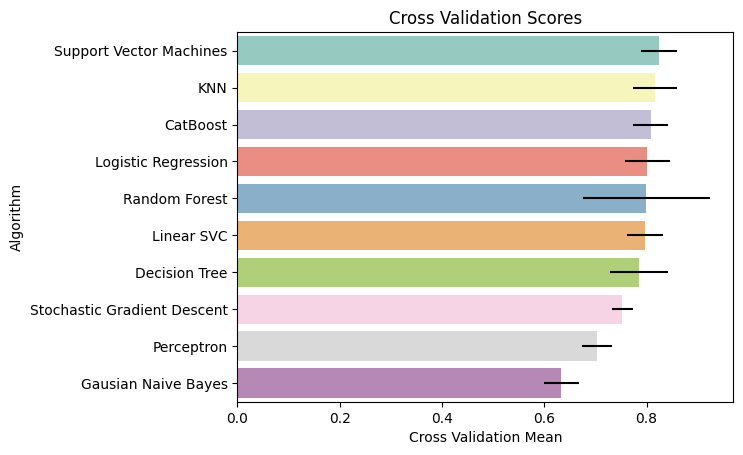

In [365]:
sns.barplot(x='Cross Validation Mean', y='Algorithm', data = cv_res ,order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

In [349]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.763 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.722 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.767 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.807 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.778 total time=   0.0s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.795 total time=   0.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.841 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.785 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.795 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.778 total time=   0.1s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.831 total time=   0.3s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.824 total time=   0.3s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.830 total time=   0.2s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [350]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.01)


In [351]:
# Training accuracy

svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.54

In [352]:
# Mean cross validation score

cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8308605720122575

In [353]:
# Survival predictions by support vector classifier

Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [354]:
len(Y_pred)

418

In [355]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [356]:
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1
